In [1]:
import pandas as pd
import nibabel as nib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import sfp 
import math
from scipy import stats
from scipy import optimize as opt
import torch
import glob
import os
import warnings
import itertools
import hessian
from torch.utils import data as torchdata

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sns.set_style('whitegrid')
#df_path = "/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-04/sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12_summary.csv"
df_path = "/mnt/prince_scratch/spatial_frequency_preferences/derivatives/first_level_analysis/stim_class/bayesian_posterior/sub-wlsubj045/ses-04/sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12_summary.csv"

Failed to import duecredit due to No module named 'duecredit'


In [7]:
sns.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False})

# Model motivation

To explain the motivation behind this model, let's step through some reasoning.

In [5]:
# Load in data
df = pd.read_csv(df_path)

Let's look at some voxels that have good GLM $R^2$ values and pick one

In [11]:
df[(df.varea==1)&(df.GLM_R2>40)].drop_duplicates('voxel').sort_values('GLM_R2', ascending=False).head(20)[['voxel', 'GLM_R2', 'varea', 'hemi', 'angle' ,'eccen', 'precision', 'prf_vexpl']]

voxel     GLM_R2  varea hemi     angle     eccen  precision  prf_vexpl
3269   3269  76.047745      1   rh  2.760368  8.217803   4.869241   0.734004
3268   3268  74.536285      1   rh  2.805402  8.353544   3.192470   0.752097
3270   3270  73.499702      1   rh  2.742864  8.085112   6.539636   0.725643
1962   1962  73.478546      1   lh  4.730360  2.853651   2.646652   0.719022
3277   3277  72.855141      1   rh  2.814290  8.130795   4.520051   0.805642
3498   3498  72.825729      1   rh  2.736296  8.276639   4.162940   0.656153
3261   3261  72.681000      1   rh  2.746991  8.333627   3.457480   0.667239
3356   3356  72.513184      1   rh  2.949604  3.009490   3.906445   0.833681
3350   3350  72.401497      1   rh  2.951332  3.168415   4.643666   0.837977
3349   3349  72.398254      1   rh  2.998524  3.205108   2.952097   0.836020
2972   2972  72.286964      1   rh  2.498455  2.088567   4.652300   0.625065
3059   3059  71.974144      1   rh  2.578800  2.256740   2.152391   0.696033
3355   3355  71.906837      1   rh  3.009597  3.089526   3.087009   0.822670
3040   3040  71.858459      1   rh  2.835505  2.601278   5.075848   0.808184
2956   2956  71.613571      1   rh  2.778346  2.350393   1.562762   0.793931
3048   3048  71.595070      1   rh  2.850946  2.452312   2.951960   0.798309
3764   3764  71.579018      1   rh  2.701077  8.680505  11.398286   0.205937
3171   3171  71.555038      1   rh  2.961612  2.925480   3.754540   0.815415
3260   3260  71.456688      1   rh  2.766411  8.418975   2.544967   0.687042
2928   2928  71.370651      1   rh  2.615927  1.807594   2.190861   0.743359

In [12]:
# Pick a V1 voxel with a good R2
voxel_df = df[(df.voxel.isin([3269]))]#, 1421]))]
voxel_df.head()

varea  voxel stimulus_superclass  w_r   w_a     eccen     angle  \
3269       1   3269             angular  0.0   6.0  8.217803  2.760368   
8947       1   3269             angular  0.0   8.0  8.217803  2.760368   
14625      1   3269             angular  0.0  11.0  8.217803  2.760368   
20303      1   3269             angular  0.0  16.0  8.217803  2.760368   
25981      1   3269             angular  0.0  23.0  8.217803  2.760368   

       stimulus_class  amplitude_estimate_std_error hemi  ...     local_w_r  \
3269                0                      0.593104   rh  ...  5.871965e-17   
8947                1                      0.485870   rh  ...  7.829287e-17   
14625               2                      0.382195   rh  ...  1.076527e-16   
20303               3                      0.482488   rh  ...  1.565857e-16   
25981               4                      0.716420   rh  ...  2.250920e-16   

       local_w_a  local_sf_magnitude  local_sf_xy_direction  \
3269    0.116203            0.116203               4.331164   
8947    0.154937            0.154937               4.331164   
14625   0.213038            0.213038               4.331164   
20303   0.309873            0.309873               4.331164   
25981   0.445443            0.445443               4.331164   

       local_sf_ra_direction  baseline  precision  amplitude_estimate_norm  \
3269                1.570796         0   4.869241                45.727131   
8947                1.570796         0   4.869241                45.727131   
14625               1.570796         0   4.869241                45.727131   
20303               1.570796         0   4.869241                45.727131   
25981               1.570796         0   4.869241                45.727131   

       amplitude_estimate_median_normed  amplitude_estimate_std_error_normed  
3269                           0.057103                             0.012971  
8947                           0.073693                             0.010625  
14625                          0.090514                             0.008358  
20303                          0.145640                             0.010551  
25981                          0.162595                             0.015667  

[5 rows x 32 columns]

Let's examine the response of this voxel as a function of spatial frequency. In the plot below, we plot the normed amplitude estimate as a function of the local spatial frequency. We see that the response looks roughly log-Normal, but there appears to be some difference between the different stimulus classes.

In [23]:
pal = sfp.plotting.stimulus_type_palette('relative')
hue_order = sfp.plotting.stimulus_type_order('relative')

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


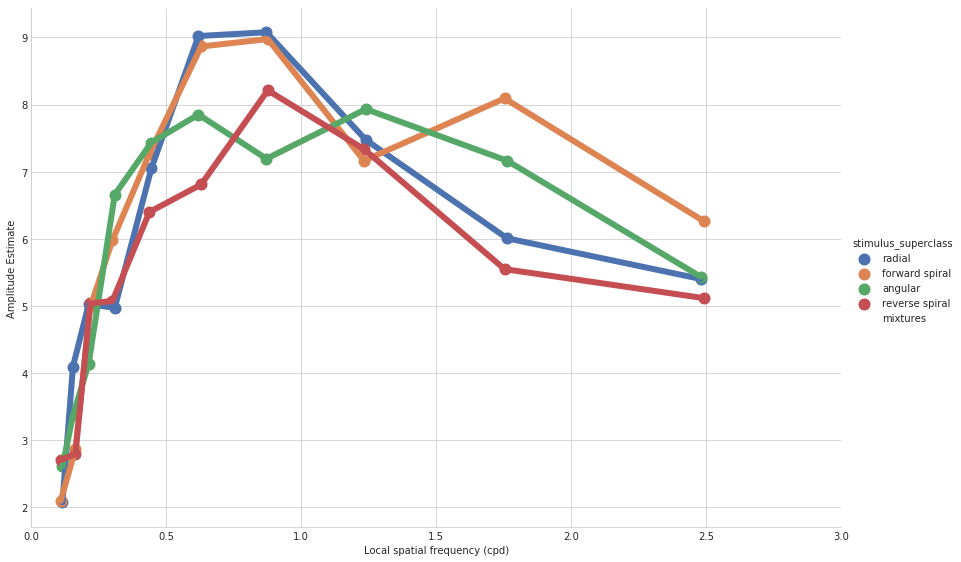

In [15]:
g = sns.FacetGrid(voxel_df[~voxel_df.stimulus_superclass.isin(['mixtures'])], hue='stimulus_superclass',palette=pal, size=8, aspect=1.5, hue_order=hue_order)
g.map(plt.scatter, 'local_sf_magnitude', 'amplitude_estimate_median', linewidth=6)
g.map(plt.plot, 'local_sf_magnitude', 'amplitude_estimate_median', linewidth=6)
# g.ax.set_xscale('log', basex=2)
g.add_legend()
g.ax.tick_params(size=0)
g.ax.set_xlim((0, 3))
g.set_xlabels('Local spatial frequency (cpd)')
g.set_ylabels('Amplitude Estimate')

These classes differ in their local orientation, so we can look at a plot of the response as a function of the local spatial frequency with respect to x and y (size represents the response). This plot is difficult to parse, but the main point is that these different stimulus classes are not arbitrary and discrete: they lie on a continuum, related by the stimulus orientation, and so we can fit the response of the voxel as a 2d tuning curve.

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, U

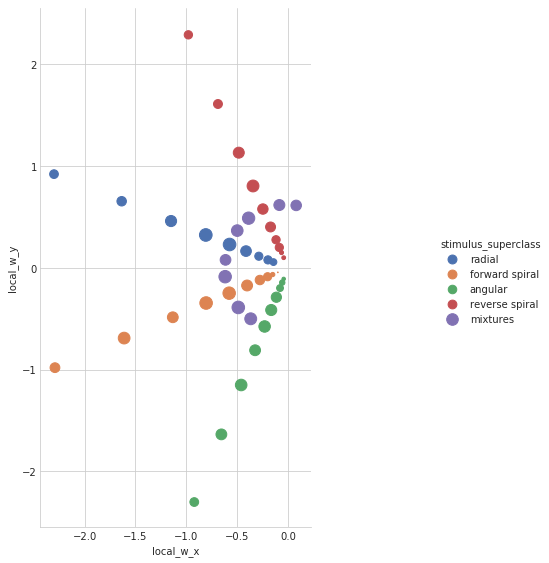

In [16]:
def scatter_sizes(x, y, s, plot_color=False, cmap=None, size_scale=1, **kwargs):
    if plot_color:
        kwargs.pop('color')
        if cmap is None:
            cmap = 'Blues'
        plt.scatter(x, y, s=s*80*size_scale, c=s, cmap=cmap, **kwargs)
    else:
        plt.scatter(x, y, s=s*80*size_scale, **kwargs)

with sns.axes_style('whitegrid'):
    voxel_df['normalized_resp'] = voxel_df['amplitude_estimate_median'].copy()
    voxel_df['normalized_resp'] = (voxel_df['normalized_resp'] - voxel_df['normalized_resp'].min()) / (voxel_df['normalized_resp'].max() - voxel_df['normalized_resp'].min())
    g=sns.FacetGrid(voxel_df, size=8, aspect=1, hue='stimulus_superclass', palette=pal, hue_order=hue_order)
    g.map(scatter_sizes, 'local_w_x', 'local_w_y', 'normalized_resp', plot_color=False, size_scale=2)
    g.add_legend()
    scatter_ax = plt.gca()
    scatter_ax.set_aspect('equal')
    g.ax.tick_params(size=0)

This is just that same data, but rotated and plotted on a semi-log plots.

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


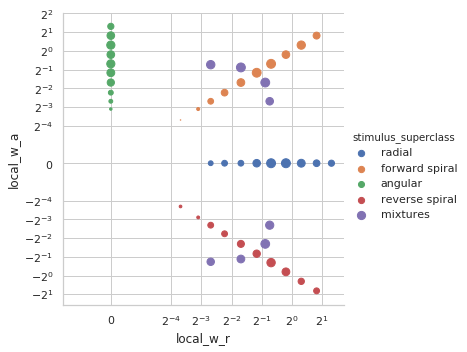

In [17]:
with sns.axes_style('whitegrid'), sns.plotting_context('notebook'):
    g=sns.FacetGrid(voxel_df, hue='stimulus_superclass', size=5, aspect=1, palette=pal, hue_order=hue_order)
    g.map(scatter_sizes, 'local_w_r', 'local_w_a', 'normalized_resp')
    g.add_legend()
    scatter_ax = plt.gca()
    scatter_ax.set_xscale('symlog', basex=2, linthreshx=2**(-4))
    scatter_ax.set_yscale('symlog', basey=2, linthreshy=2**(-4))

But then the question is: how does the tuning change with orientation? Two possibilities are:

1. The preferred frequency of the tuning curve / mode of the log-Gaussian distribution changes with orientation.
2. The amplitude of the tuning curve changes with orientation.

Then there's the question of how either the mode or the amplitude changes with orientation. Let's assume it changes smoothly and periodically, symmetrically about 180 degrees (because 2d orientation is runs from 0 to 180 degrees). We'll examine three possibilities:

1. all orientation are equally important (mode/amplitude does not depend on orientation; constant)
2. horizontal or vertical is preferred, but the other is anti-preferred (sinusoid with frequency $2\theta$)
3. the cardinals are preferred, the obliques are anti-preferred (or vice-versa, sinusoid with frequency $4\theta$)

I'll build up the complexity of the model, adding terms (and plots) to show additional possibilities that we're modeling. However, note that there are several things we are *not* modeling:

- Categorical differences between upper and lower; left and right; foveal, parafoveal, and peripheral visual field (some elements of these are caught by our parameterization, but not in any complete sense; we are modeling them separately as well to see if there's a difference in the parameters found)
- Voxel-to-voxel differences in the max response amplitude; there's too much confounding with blood vessel location and other non-neural factors, so we only model the variation in max amplitude *within* voxels

There are lots of ways to show this. For our purposes, we're going to show three types of plots:

1. Preferred period of vs. eccentricity, with separate plots for different retinotopic angles, and color used to show different stimulus types (which contain different orientation information)
2. Preferred period contour plots, polar plots that shows the eccentricity where we have a specific preferred period at different retinotopic angles. As above, color shows different stimulus types.
3. Max amplitude plots, polar plots that show the maximum amplitude of the response at each  polar angle, where (as above) color shows different stimulus types (note that there's no interaction between this and  eccentricity or preferred period).

We'll build up the complexity of these examples, starting with the simplest and getting more complex as we go.

As we mentioned, we noticed the response looked roughly log-normal, so we start with that:

$\hat{\beta} = A \exp\left(\frac{-(\log_2\omega+\log_2p)^2}{2\sigma^2} \right)$

Here:
- $\hat{\beta}$: our prediction of the voxel's response, $\beta$ (defined as the estimate give by `GLMdenoise`) of a given voxel to a given stimulus
- $\omega$: the spatial frequency content of the stimulus at the center of the voxel's population receptive field
- $p$: the preferred period of this voxel
- $\sigma$: the bandwidth of this voxel's response (in octaves)
- $A$: the voxel's max response amplitude

This here is what we were fitting in our first pass analysis, as seen in notebook `04-MRI-first-level`; for each eccentricity band and stimulus class, we fit all three parameters ($p$, $\sigma$, and $A$) separately, and then plotted them out as a function of eccentricity to see their relationship.

Now, we're interested in parameterizing the relationship between these parameters and the voxel's eccentricity, retinotopic angle, and the stimulus's local orientation information. The simplest way we'll do this, corresponding to the largest effect we saw, is to say that retinotopic angle and stimulus local orientation don't matter and that the preferred period is some linear function of eccentricity, $e$:

$p=ae+b$

where we fit $a$ and $b$ across all voxels and stimuli. Note that we now fit the same $\sigma$ to all voxels (but since it's in octaves, there's an implicit scaling here). We don't actually fit $A$ here, since we normalize each voxel's response in our loss function, so any constant value for $A$ will be equivalent.

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


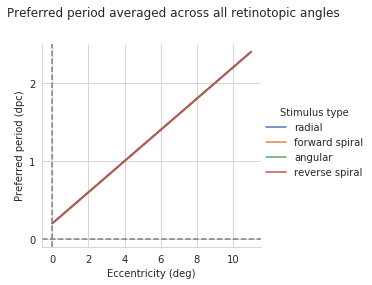

In [35]:
m = sfp.model.LogGaussianDonut(vary_amplitude=False, sf_ecc_slope=.2, sf_ecc_intercept=.2, orientation_type='full', abs_mode_cardinals=0)
tmp = sfp.analyze_model.create_preferred_period_df(m, reference_frame='relative',)
g = sfp.plotting.feature_df_plot(tmp, col=None, title='Preferred period averaged across all retinotopic angles', ylim=(-.1, 2.5))

For this simple model, there's on effect of retinotopic angle or stimulus orientation, so we won't look at any other plots.

However, we can look at the effect of changing these two parameters, $a$ and $b$, which do what you expect:

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


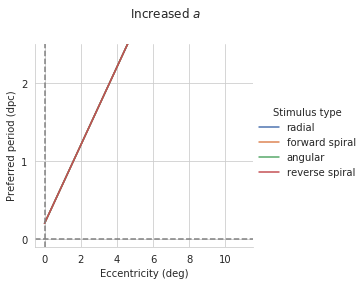

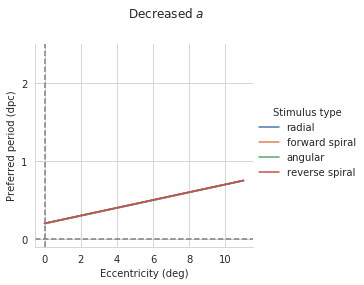

In [34]:
m = sfp.model.LogGaussianDonut(vary_amplitude=False, sf_ecc_slope=.5, sf_ecc_intercept=.2, orientation_type='full', abs_mode_cardinals=0)
tmp = sfp.analyze_model.create_preferred_period_df(m, reference_frame='relative',)
g = sfp.plotting.feature_df_plot(tmp, col=None, title='Increased $a$', ylim=(-.1, 2.5))

m = sfp.model.LogGaussianDonut(vary_amplitude=False, sf_ecc_slope=.05, sf_ecc_intercept=.2, orientation_type='full', abs_mode_cardinals=0)
tmp = sfp.analyze_model.create_preferred_period_df(m, reference_frame='relative',)
g = sfp.plotting.feature_df_plot(tmp, col=None, title='Decreased $a$', ylim=(-.1, 2.5))

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


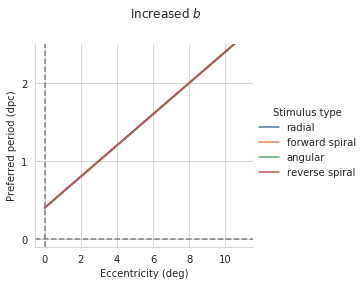

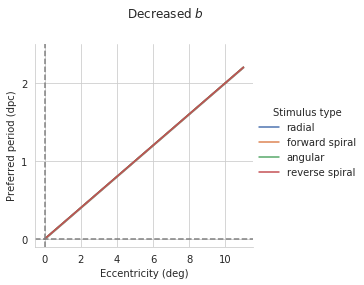

In [36]:
m = sfp.model.LogGaussianDonut(vary_amplitude=False, sf_ecc_slope=.2, sf_ecc_intercept=.4, orientation_type='full', abs_mode_cardinals=0)
tmp = sfp.analyze_model.create_preferred_period_df(m, reference_frame='relative',)
g = sfp.plotting.feature_df_plot(tmp, col=None, title='Increased $b$', ylim=(-.1, 2.5))

m = sfp.model.LogGaussianDonut(vary_amplitude=False, sf_ecc_slope=.2, sf_ecc_intercept=0, orientation_type='full', abs_mode_cardinals=0)
tmp = sfp.analyze_model.create_preferred_period_df(m, reference_frame='relative',)
g = sfp.plotting.feature_df_plot(tmp, col=None, title='Decreased $b$', ylim=(-.1, 2.5))

Alright, now we're going to make things more complicated by parameterizing an effect of stimulus orientation and voxel retinotopic angle on the preferred period:

$\hat{\beta} = A \exp\left(\frac{-(\log_2\omega+\log_2p)^2}{2\sigma^2} \right)$

$p=(ae+b)(1+p_1\cos 2\theta + p_2\cos 4\theta + p_3\cos 2(\theta-\phi) + p_4\cos 4(\theta-\phi))$

where all parameters are as before and we now have two new variables:
- $\theta$: the stimulus local orientation information at the center of the voxel's population receptive field
- $\phi$: the retinotopic angle of the voxel's population receptive field

and the new $p_i$ parameters control the size of the effects on the preferred period:
- $p_1$: absolute cardinal effect, horizontal vs. vertical
- $p_2$: absolute cardinals vs. obliques effect, horizontal/vertical vs. diagonals
- $p_3$: relative cardinal effect, radial vs. angular
- $p_4$: relative cardinals vs. obliques effect, radial/angular vs. spirals

Note that we're saying the effect of eccentricity and retinotopic angle / orientation are multiplied together, that they have separable effects on the preferred period.

Let's first consider a model that has $p_3=p_4=0$ and $p_1>p_2>0$, that is, where there's only an effect of absolute orientation and the effect of vertical vs. horizontal is larger than that of cardinals vs. obliques.

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


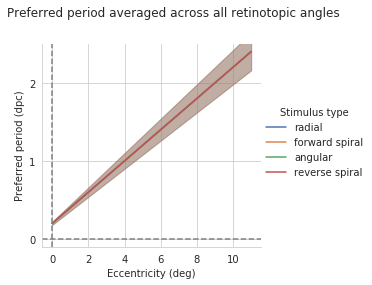

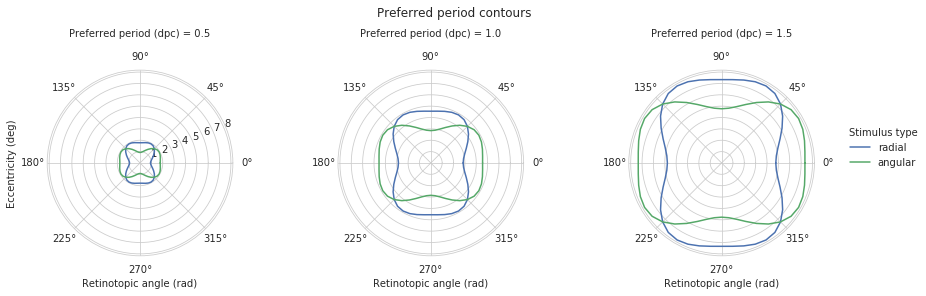

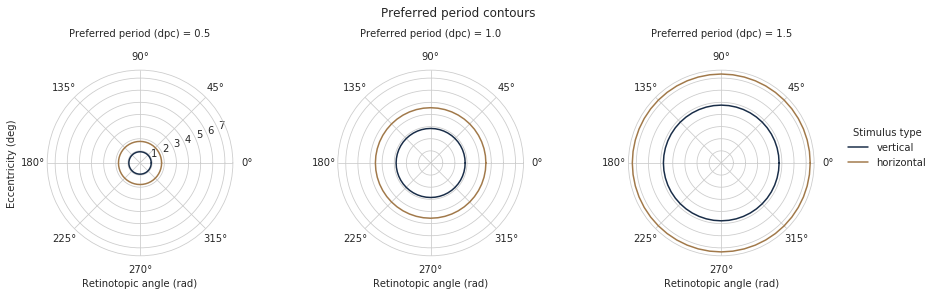

In [65]:
m = sfp.model.LogGaussianDonut(vary_amplitude=False, sf_ecc_slope=.2, sf_ecc_intercept=.2, orientation_type='full', abs_mode_cardinals=.2, abs_mode_obliques=.1)

tmp = sfp.analyze_model.create_preferred_period_df(m, reference_frame='relative',)
g = sfp.plotting.feature_df_plot(tmp, col=None, title='Preferred period averaged across all retinotopic angles', ylim=(-.1, 2.5))

tmp = sfp.analyze_model.create_preferred_period_contour_df(m, reference_frame='relative', orientation=np.linspace(0, np.pi, 2, endpoint=False),)
g = sfp.plotting.feature_df_polar_plot(tmp, )
tmp = sfp.analyze_model.create_preferred_period_contour_df(m, reference_frame='absolute', orientation=np.linspace(0, np.pi, 2, endpoint=False))
g = sfp.plotting.feature_df_polar_plot(tmp)

Now we'll look at these plots again, to see what happens when we increase $p_1$

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


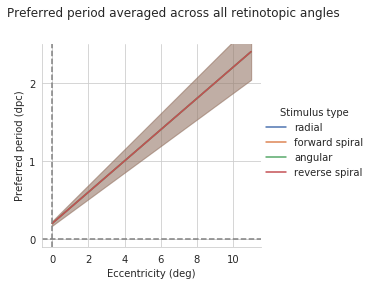

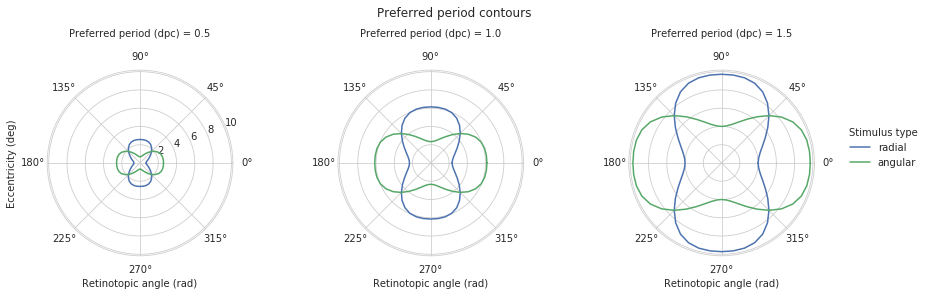

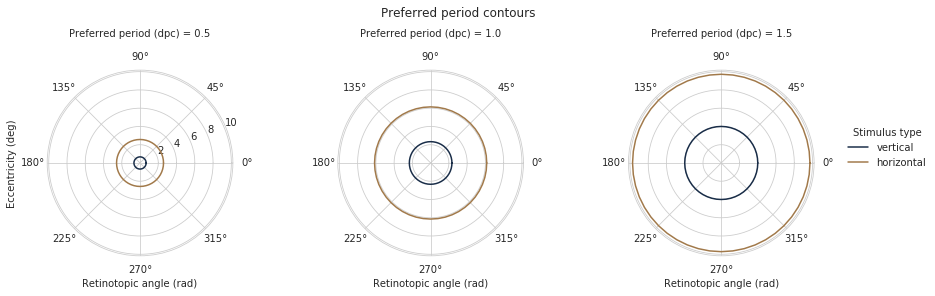

In [69]:
m = sfp.model.LogGaussianDonut(vary_amplitude=False, sf_ecc_slope=.2, sf_ecc_intercept=.2, orientation_type='full', abs_mode_cardinals=.4, abs_mode_obliques=.1)

tmp = sfp.analyze_model.create_preferred_period_df(m, reference_frame='relative',)
g = sfp.plotting.feature_df_plot(tmp, col=None, title='Preferred period averaged across all retinotopic angles', ylim=(-.1, 2.5))

tmp = sfp.analyze_model.create_preferred_period_contour_df(m, reference_frame='relative', orientation=np.linspace(0, np.pi, 2, endpoint=False),)
g = sfp.plotting.feature_df_polar_plot(tmp, )
tmp = sfp.analyze_model.create_preferred_period_contour_df(m, reference_frame='absolute', orientation=np.linspace(0, np.pi, 2, endpoint=False))
g = sfp.plotting.feature_df_polar_plot(tmp)

... when we make $p_1=p_2$

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


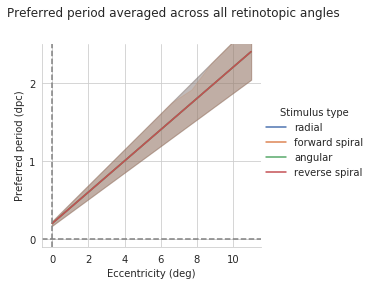

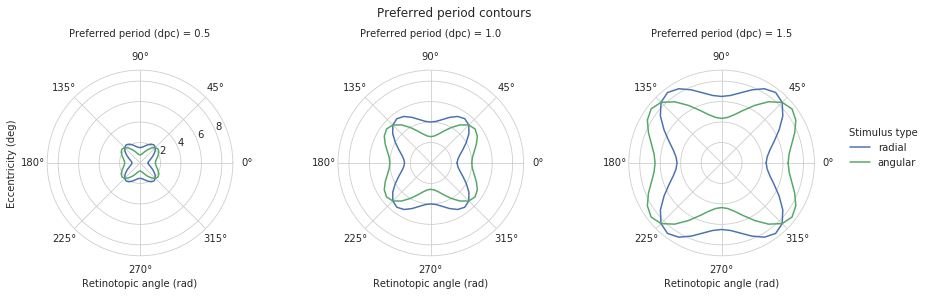

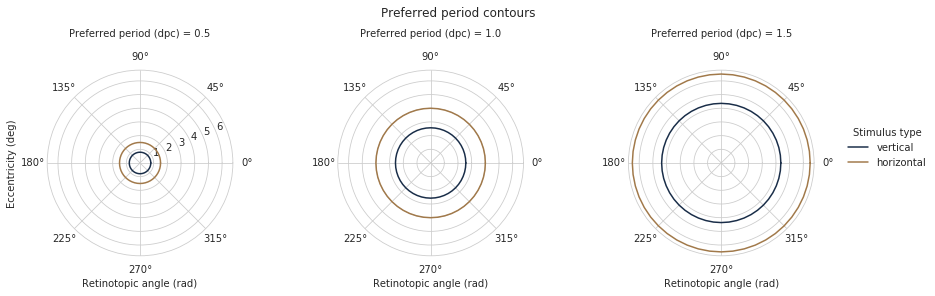

In [70]:
m = sfp.model.LogGaussianDonut(vary_amplitude=False, sf_ecc_slope=.2, sf_ecc_intercept=.2, orientation_type='full', abs_mode_cardinals=.2, abs_mode_obliques=.2)

tmp = sfp.analyze_model.create_preferred_period_df(m, reference_frame='relative',)
g = sfp.plotting.feature_df_plot(tmp, col=None, title='Preferred period averaged across all retinotopic angles', ylim=(-.1, 2.5))

tmp = sfp.analyze_model.create_preferred_period_contour_df(m, reference_frame='relative', orientation=np.linspace(0, np.pi, 2, endpoint=False),)
g = sfp.plotting.feature_df_polar_plot(tmp, )
tmp = sfp.analyze_model.create_preferred_period_contour_df(m, reference_frame='absolute', orientation=np.linspace(0, np.pi, 2, endpoint=False))
g = sfp.plotting.feature_df_polar_plot(tmp)

... and we make $p_1<p_2$

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


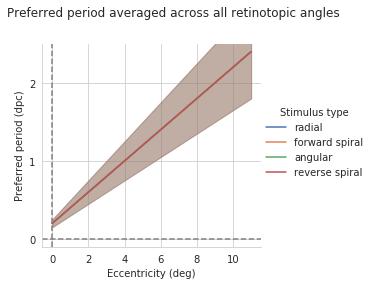

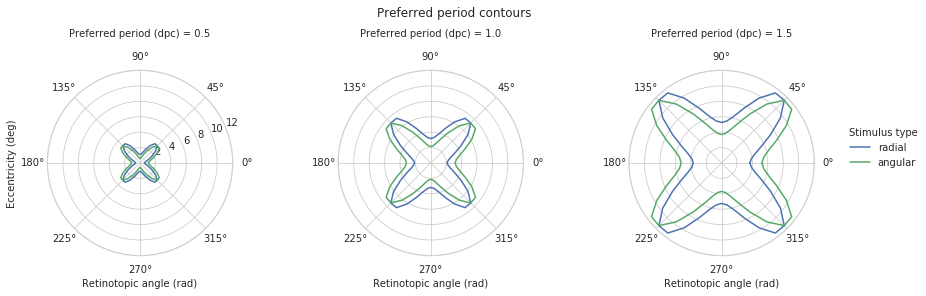

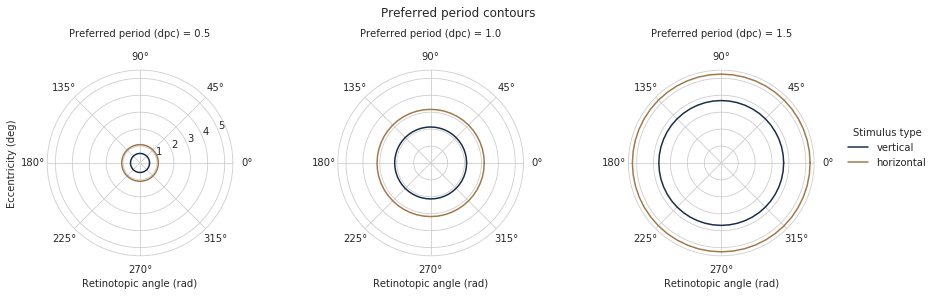

In [71]:
m = sfp.model.LogGaussianDonut(vary_amplitude=False, sf_ecc_slope=.2, sf_ecc_intercept=.2, orientation_type='full', abs_mode_cardinals=.2, abs_mode_obliques=.4)

tmp = sfp.analyze_model.create_preferred_period_df(m, reference_frame='relative',)
g = sfp.plotting.feature_df_plot(tmp, col=None, title='Preferred period averaged across all retinotopic angles', ylim=(-.1, 2.5))

tmp = sfp.analyze_model.create_preferred_period_contour_df(m, reference_frame='relative', orientation=np.linspace(0, np.pi, 2, endpoint=False),)
g = sfp.plotting.feature_df_polar_plot(tmp, )
tmp = sfp.analyze_model.create_preferred_period_contour_df(m, reference_frame='absolute', orientation=np.linspace(0, np.pi, 2, endpoint=False))
g = sfp.plotting.feature_df_polar_plot(tmp)

And now let's set $p_1=p_2=0$ and look at the effects of $p_3$ and $p_4$, with $p_3 > p_4$

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


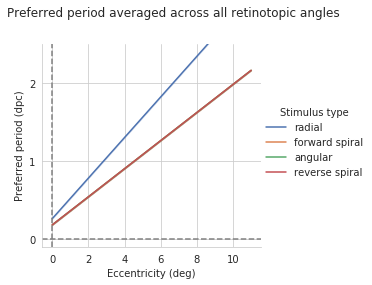

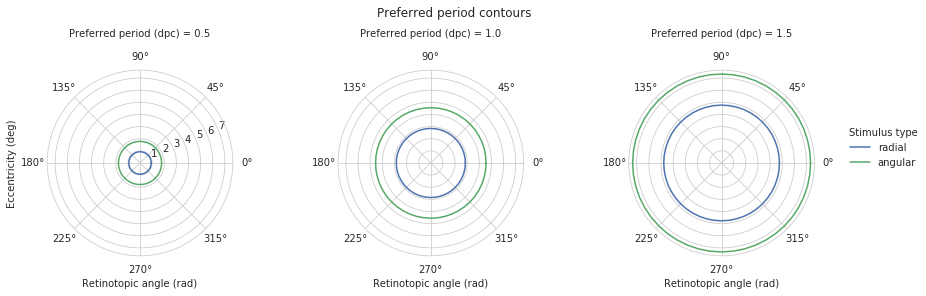

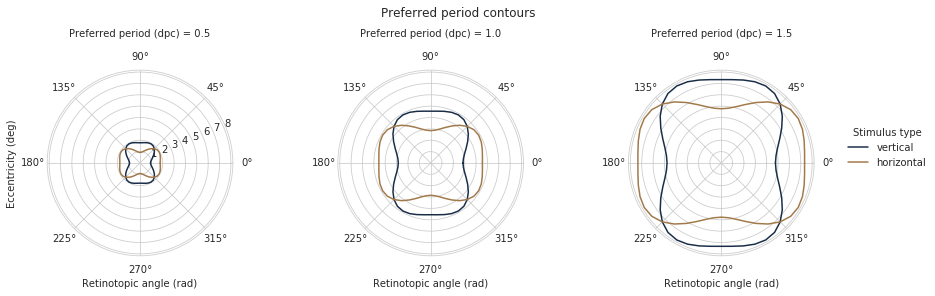

In [72]:
m = sfp.model.LogGaussianDonut(vary_amplitude=False, sf_ecc_slope=.2, sf_ecc_intercept=.2, orientation_type='full', rel_mode_cardinals=.2, rel_mode_obliques=.1)

tmp = sfp.analyze_model.create_preferred_period_df(m, reference_frame='relative',)
g = sfp.plotting.feature_df_plot(tmp, col=None, title='Preferred period averaged across all retinotopic angles', ylim=(-.1, 2.5))

tmp = sfp.analyze_model.create_preferred_period_contour_df(m, reference_frame='relative', orientation=np.linspace(0, np.pi, 2, endpoint=False),)
g = sfp.plotting.feature_df_polar_plot(tmp, )
tmp = sfp.analyze_model.create_preferred_period_contour_df(m, reference_frame='absolute', orientation=np.linspace(0, np.pi, 2, endpoint=False))
g = sfp.plotting.feature_df_polar_plot(tmp)

... when we increase $p_3$

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


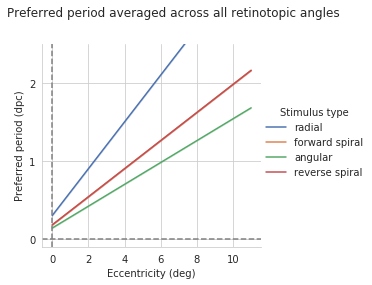

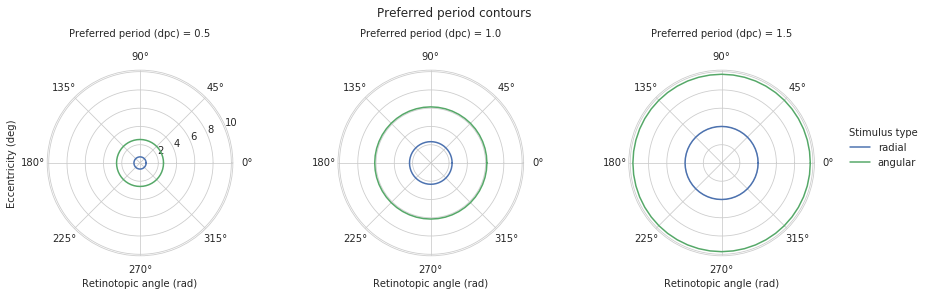

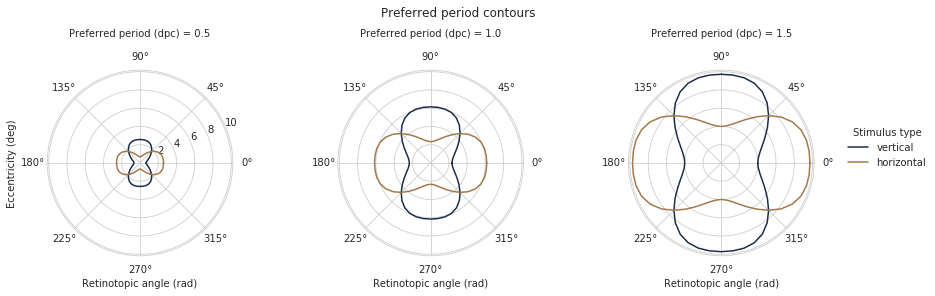

In [73]:
m = sfp.model.LogGaussianDonut(vary_amplitude=False, sf_ecc_slope=.2, sf_ecc_intercept=.2, orientation_type='full', rel_mode_cardinals=.4, rel_mode_obliques=.1)

tmp = sfp.analyze_model.create_preferred_period_df(m, reference_frame='relative',)
g = sfp.plotting.feature_df_plot(tmp, col=None, title='Preferred period averaged across all retinotopic angles', ylim=(-.1, 2.5))

tmp = sfp.analyze_model.create_preferred_period_contour_df(m, reference_frame='relative', orientation=np.linspace(0, np.pi, 2, endpoint=False),)
g = sfp.plotting.feature_df_polar_plot(tmp, )
tmp = sfp.analyze_model.create_preferred_period_contour_df(m, reference_frame='absolute', orientation=np.linspace(0, np.pi, 2, endpoint=False))
g = sfp.plotting.feature_df_polar_plot(tmp)

... when $p_3 = p_4$

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


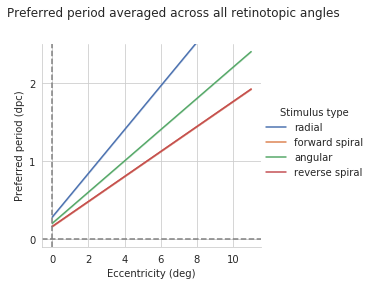

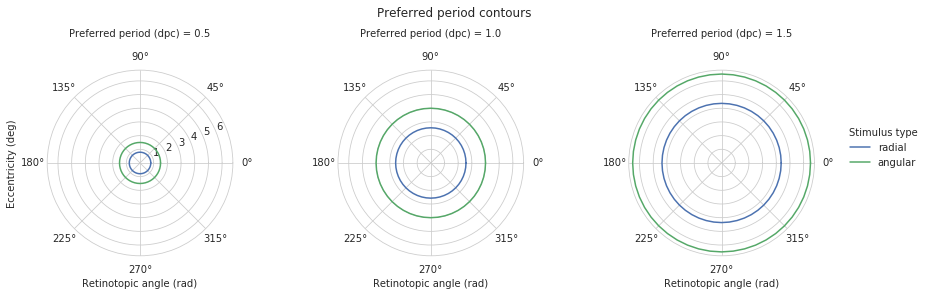

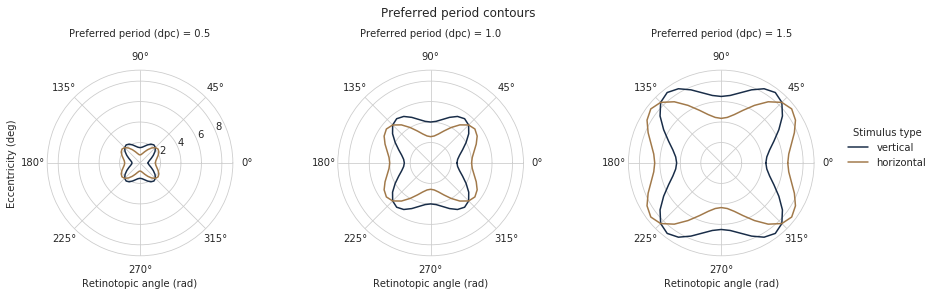

In [74]:
m = sfp.model.LogGaussianDonut(vary_amplitude=False, sf_ecc_slope=.2, sf_ecc_intercept=.2, orientation_type='full', rel_mode_cardinals=.2, rel_mode_obliques=.2)

tmp = sfp.analyze_model.create_preferred_period_df(m, reference_frame='relative',)
g = sfp.plotting.feature_df_plot(tmp, col=None, title='Preferred period averaged across all retinotopic angles', ylim=(-.1, 2.5))

tmp = sfp.analyze_model.create_preferred_period_contour_df(m, reference_frame='relative', orientation=np.linspace(0, np.pi, 2, endpoint=False),)
g = sfp.plotting.feature_df_polar_plot(tmp, )
tmp = sfp.analyze_model.create_preferred_period_contour_df(m, reference_frame='absolute', orientation=np.linspace(0, np.pi, 2, endpoint=False))
g = sfp.plotting.feature_df_polar_plot(tmp)

... when $p_3 < p_4$

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


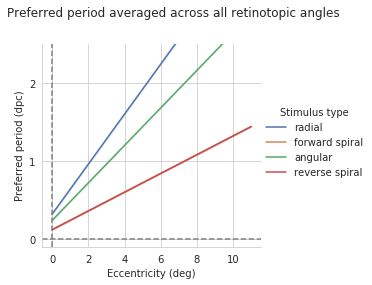

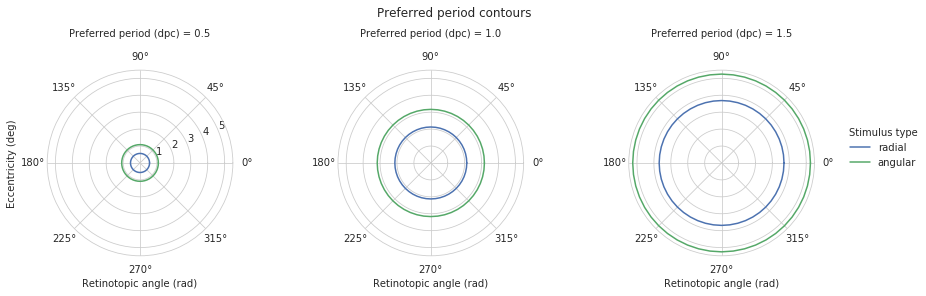

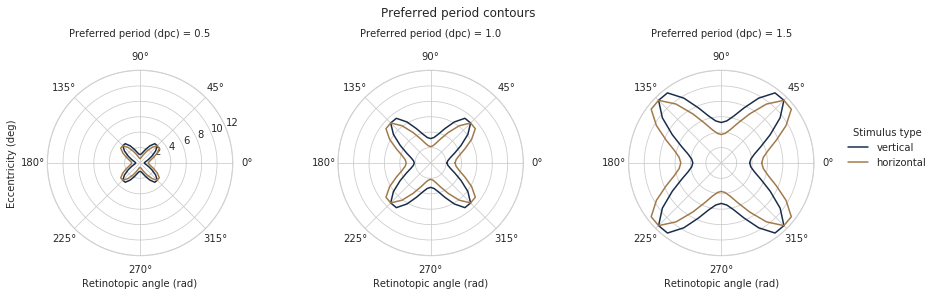

In [75]:
m = sfp.model.LogGaussianDonut(vary_amplitude=False, sf_ecc_slope=.2, sf_ecc_intercept=.2, orientation_type='full', rel_mode_cardinals=.2, rel_mode_obliques=.4)

tmp = sfp.analyze_model.create_preferred_period_df(m, reference_frame='relative',)
g = sfp.plotting.feature_df_plot(tmp, col=None, title='Preferred period averaged across all retinotopic angles', ylim=(-.1, 2.5))

tmp = sfp.analyze_model.create_preferred_period_contour_df(m, reference_frame='relative', orientation=np.linspace(0, np.pi, 2, endpoint=False),)
g = sfp.plotting.feature_df_polar_plot(tmp, )
tmp = sfp.analyze_model.create_preferred_period_contour_df(m, reference_frame='absolute', orientation=np.linspace(0, np.pi, 2, endpoint=False))
g = sfp.plotting.feature_df_polar_plot(tmp)

And we do the same thing with amplitude, parameterizing it as:

$\hat{\beta} = A \exp\left(\frac{-(\log_2\omega+\log_2p)^2}{2\sigma^2} \right)$

$p=(ae+b)(1+p_1\cos 2\theta + p_2\cos 4\theta + p_3\cos 2(\theta-\phi) + p_4\cos 4(\theta-\phi))$

$A=(1+A_1\cos 2\theta + A_2\cos 4\theta + A_3\cos 2(\theta-\phi) + A_4\cos 4(\theta-\phi))$


## Model variants

That seems like a lot of potential parameters (11 total); are they all necessary? We'll fit different variants of the model, each fitting different subsets of the parameters, and use cross-validation to see which fits best

In [2]:
model_names = ['constant iso', 'scaling iso', 'full iso', 'full absolute', 'full relative', 'full full', 'full absolute amps', 'full relative amps', 'full full amps']
parameters = [r'$\sigma$', r'$a$', r'$b$', r'$p_1$', r'$p_2$', r'$p_3$', r'$p_4$', r'$A_1$', r'$A_2$', r'$A_3$', r'$A_4$']
model_variants = np.zeros((len(model_names), len(parameters))).astype(bool)
# everyone fits sigma
model_variants[:, 0] = True
model_variants[1:, 1] = True
model_variants[0, 2] = True
model_variants[2:, 2] = True
model_variants[3, [3, 4]] = True
model_variants[4, [5, 6]] = True
model_variants[5, [3, 4, 5, 6]] = True
model_variants[6, [3, 4, 7, 8]] = True
model_variants[7, [5, 6, 9, 10]] = True
model_variants[8, 3:] = True

In [5]:
model_variants = pd.DataFrame(model_variants, model_names, parameters)
green, red = sns.color_palette('deep', 4)[2:]
pal = sns.blend_palette([red, green])

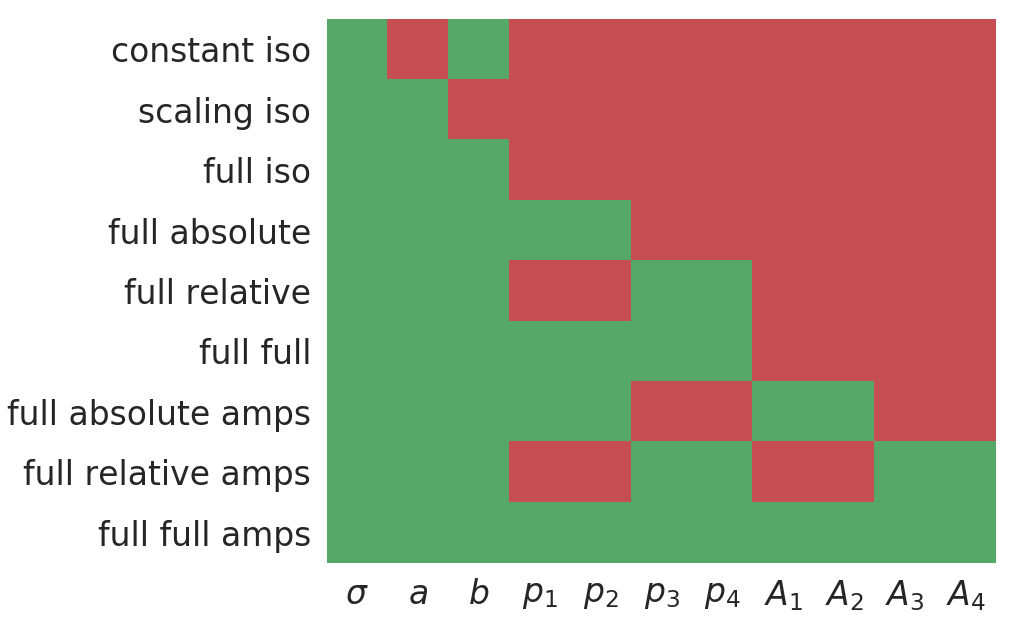

In [6]:
with sns.plotting_context('poster', font_scale=1.5):
    fig = plt.figure(figsize=(12,10))
    ax = sns.heatmap(model_variants, cmap=pal, cbar=False, )
    ax.set_yticklabels(model_names, rotation=0)

# Voxel precision

One of the things we care about is the noisiness of our voxels. We'll use this in our loss function, so we want to know whether we can just use the noise we've calculated on a voxel-by-voxel basis or whether we have to worry about differing levels of noise for different stimulus classes.

In [7]:
df = pd.read_csv(df_path)

What's unclear from the following plot is whether the apparent relationship between the median amplitude estimate and the error is because of differences *between* voxels or *within* them. If it's between voxels, we're fine, but it's bad if it's within them (this would be like for a Poisson-process neuron, whose variance increases with the mean firing rate)

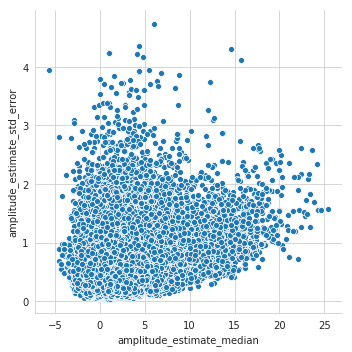

In [8]:
sns.relplot(x='amplitude_estimate_median', y='amplitude_estimate_std_error', data=df)

So to answer this question, we do a simple linear regression between the median amplitude estimate and the standard error.

In [9]:
def linear_regression(data, x='amplitude_estimate_median', y='amplitude_estimate_std_error'):
    s,i,r,p,e = stats.linregress(data[x], data[y])
    return pd.Series({'slope': s, 'intercept': i, 'r_squared': r**2, 'p_value': p, 'stderr': e})

linregress = df.groupby('voxel').apply(linear_regression)

And what we see here is that there doesn't appear to be a consistent relationship between the median amplitude estimate and the error of those estimates: the slope looks like it's distributed around zero, as does the relationship between slope and intercept. This is good, so we can treat precision as a voxel-by-voxel number

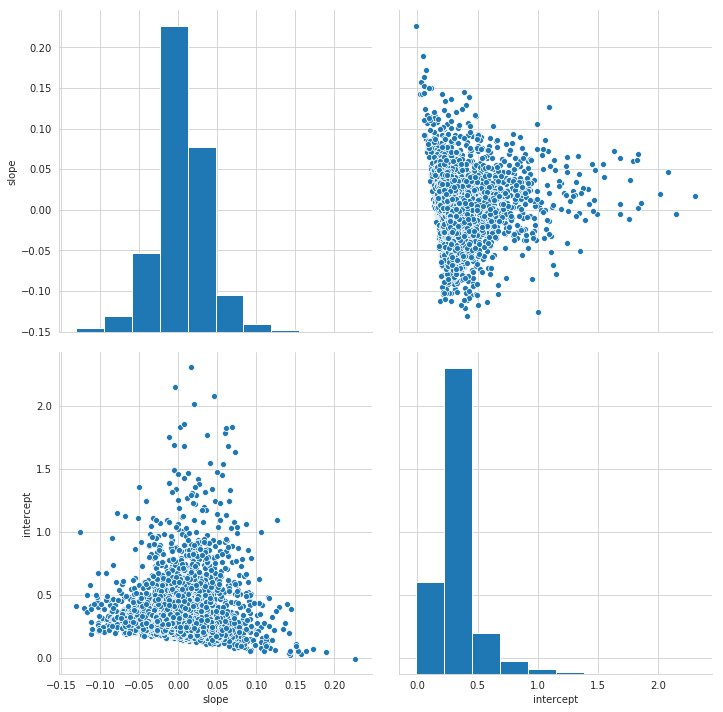

In [10]:
sns.pairplot(linregress, vars=['slope', 'intercept'], height=5)

Since we're happy with that, we'll use the loss function:

$L(\beta,\hat{\beta})=\frac{1}{\sigma_v^2}\left(\frac{\beta}{||\beta||} - \frac{\hat{\beta}}{||\hat{\beta}||} \right)$

This is the cosine similarity. It's similar to the Pearson correlation, except that it's not de-meaned (see this [StackOverflow post](https://stackoverflow.com/a/27393770) for a bit more information)

# Analyzing outputs

## Learning hyperparameters

There's a huge amount of information to wade through here, since I'm looking at 3 learning rates by 3 batch sizes by 2 true models by 2 fit models, with the goal of finding out what combination of learning rates, batch sizes, and thresholds make the most sense.

We're going to go with `batch_size=10`, `learning_rate=1e-3`, which finds the correct parameters (as long as that's possible) and finishes in a reasonable number of epochs. Compared to `batch_size=1`, each epoch is faster; this isn't enough to make it finish in a quicker amount of time, but it always finds the correct solution, which `batch_size=1` does not.

In [11]:
base_str = '/mnt/prince_scratch/spatial_frequency_preferences/derivatives/tuning_2d_simulated/noise-stim_class_bayesian_posterior_sub-wlsubj045_ses-02_task-sfp_v1_e1-12/learning_hyperparams_full/g0_all_'
models = pd.read_csv(base_str + 'models.csv')
model_history = pd.read_csv(base_str + 'model_history.csv')
timing_df = pd.read_csv(base_str + 'timing.csv')
avg_loss = pd.read_csv(base_str + 'loss.csv')
loss_df = pd.read_csv(base_str + 'diff.csv')

In [12]:
# hack to deal with this issue, hopefully fixed soon: https://github.com/mwaskom/seaborn/issues/1560
avg_loss.fit_model_type = avg_loss.fit_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))
loss_df.fit_model_type = loss_df.fit_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))
models.fit_model_type = models.fit_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))
model_history.fit_model_type = model_history.fit_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))
timing_df.fit_model_type = timing_df.fit_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))

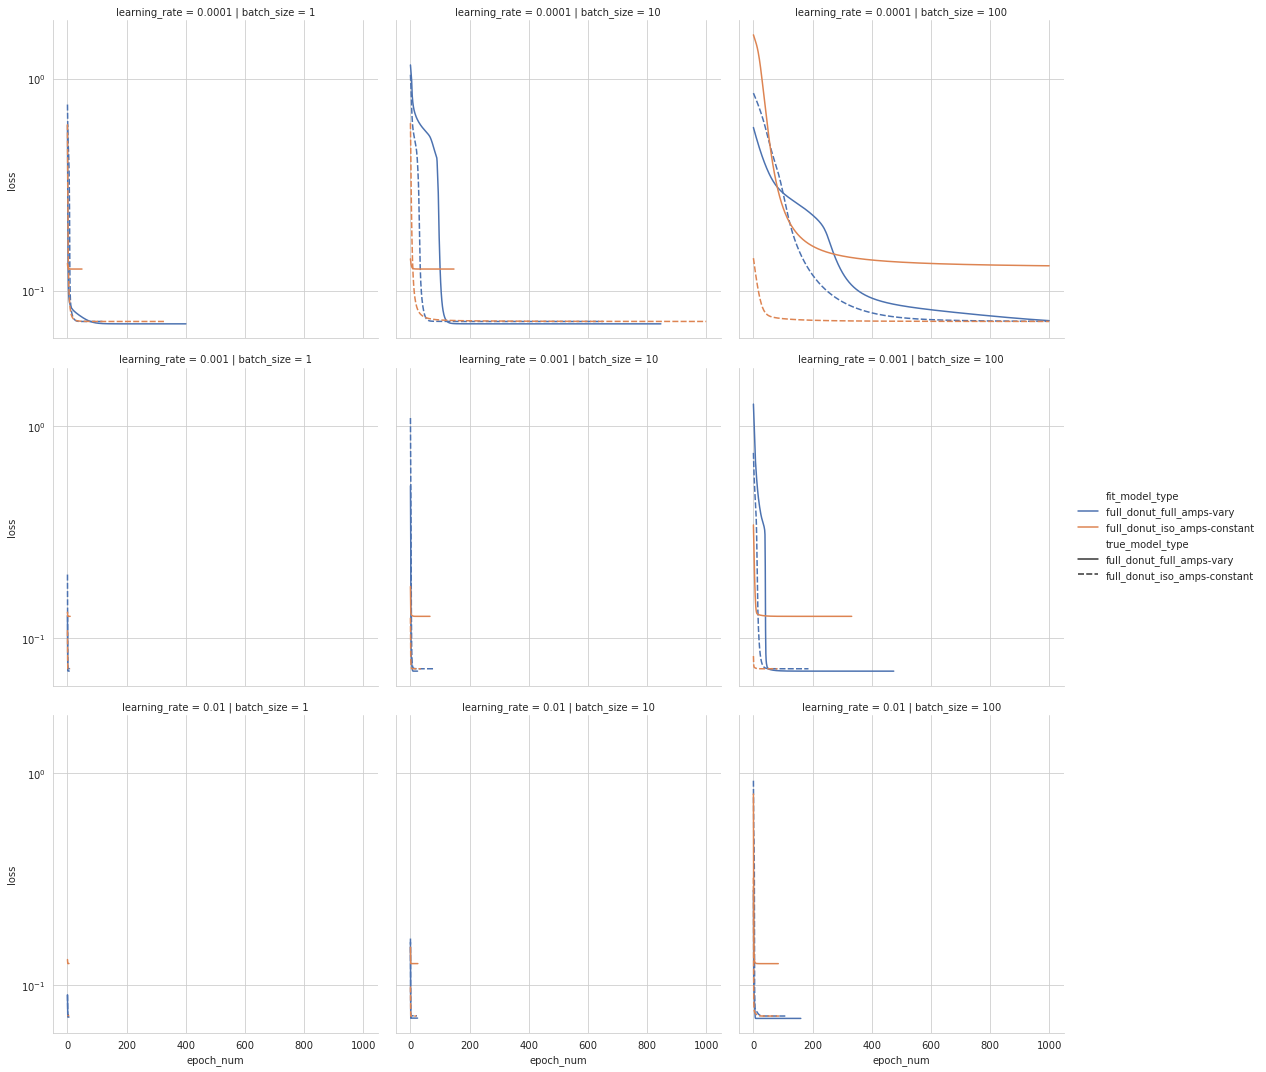

In [13]:
g = sns.relplot('epoch_num', 'loss', 'fit_model_type', style='true_model_type', data=loss_df, col='batch_size', row='learning_rate', 
                kind='line', ci='sd', palette=sns.color_palette('deep', 2) )
                #facet_kws={'sharey':False, 'sharex': False})
for ax in g.axes.flatten():
    ax.set_yscale('log', basey=10)

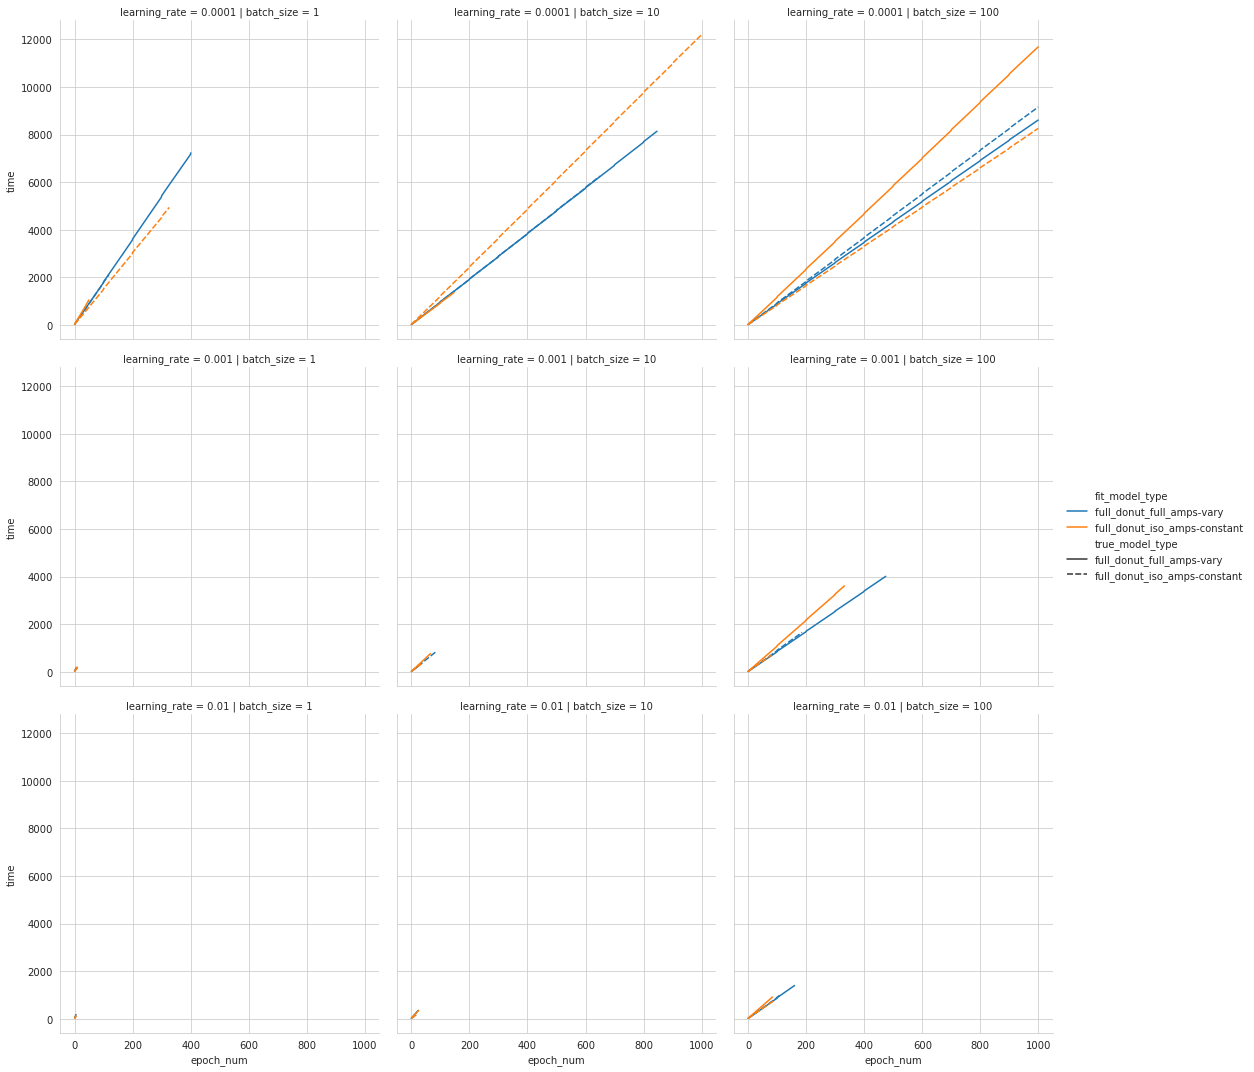

In [14]:
g=sns.relplot('epoch_num', 'time', 'fit_model_type', style='true_model_type', data=timing_df, col='batch_size', row='learning_rate', kind='line', legend='full')

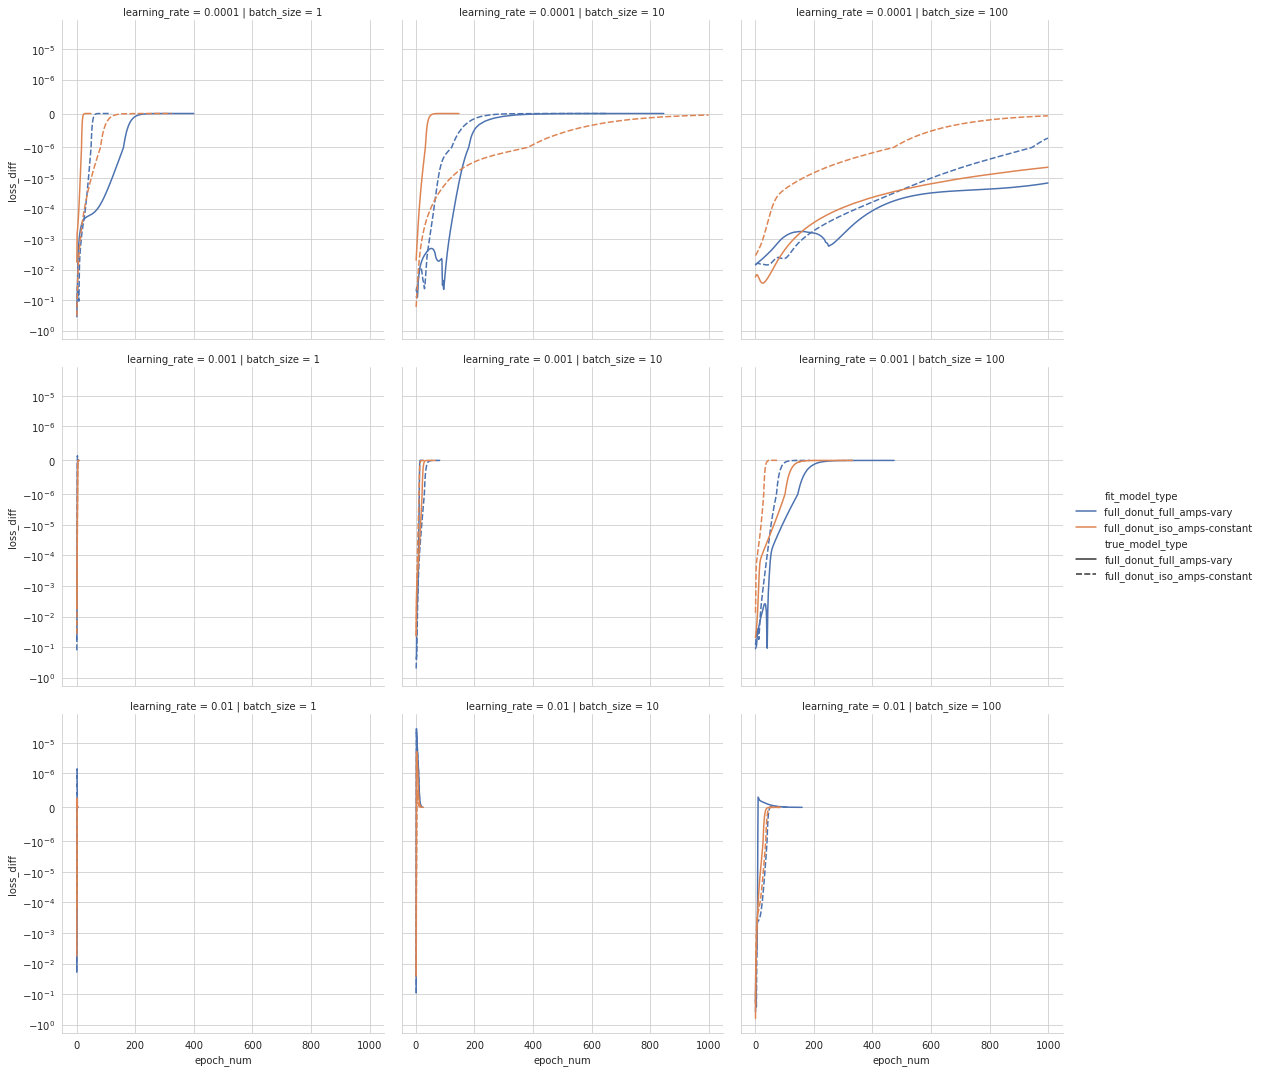

In [15]:
g = sns.relplot('epoch_num', 'loss_diff', 'fit_model_type', style='true_model_type', data=loss_df, col='batch_size', row='learning_rate', 
                kind='line', ci='sd', palette=sns.color_palette('deep', 2) )
                #facet_kws={'sharey':False, 'sharex': False})
for ax in g.axes.flatten():
    ax.set_yscale('symlog', basey=10, linthreshy=1e-6)

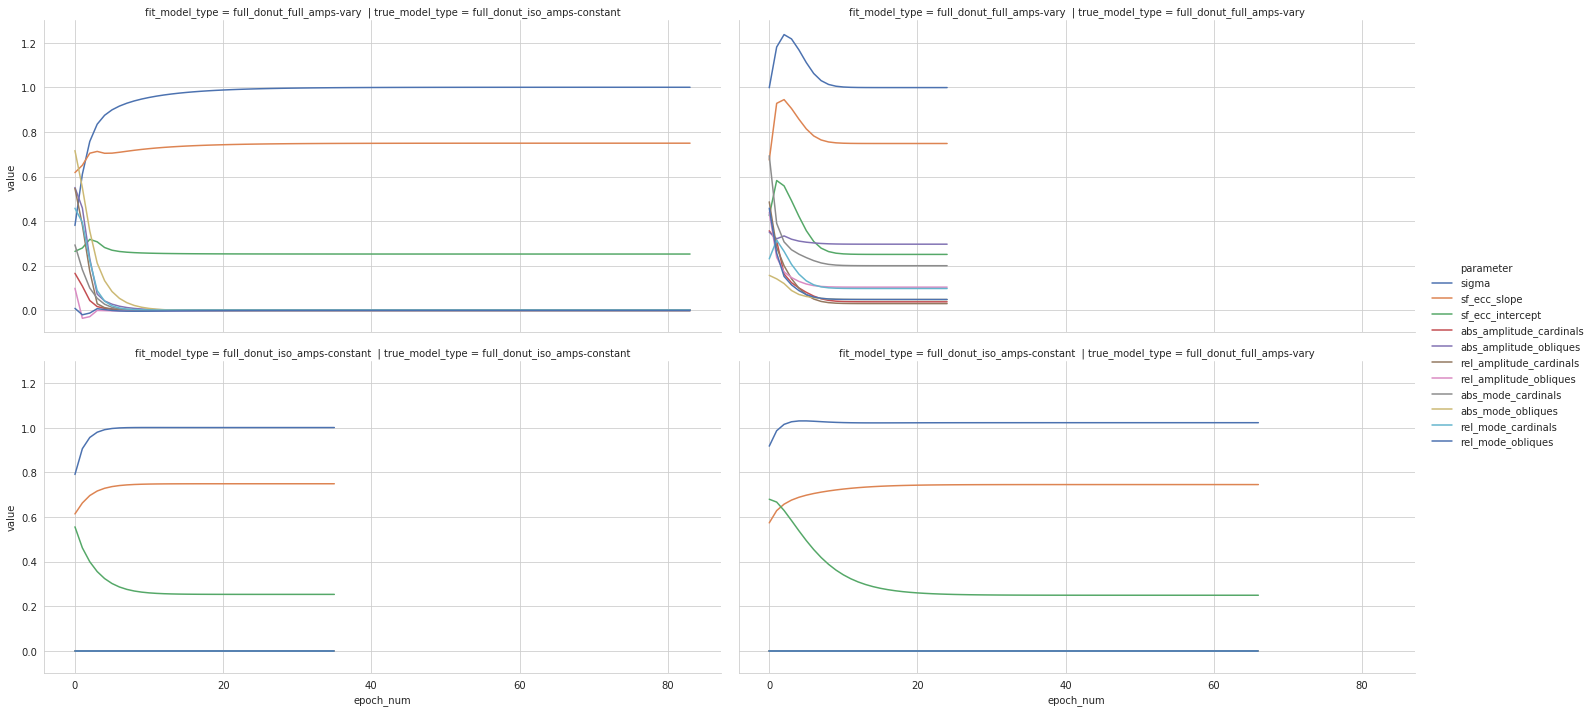

In [16]:
g=sns.relplot('epoch_num', 'value', 'parameter', row='fit_model_type', col='true_model_type', hue_order=sfp.plotting.PARAM_ORDER,# col='batch_size', row='learning_rate', 
              data=model_history.query("learning_rate==1e-3 & batch_size==10"), kind='line', aspect=2,
              ci='sd', palette=sns.color_palette('deep', 11))#facet_kws={'sharey': False})

This is really bad, looks like the model thinks we know nothing about anything

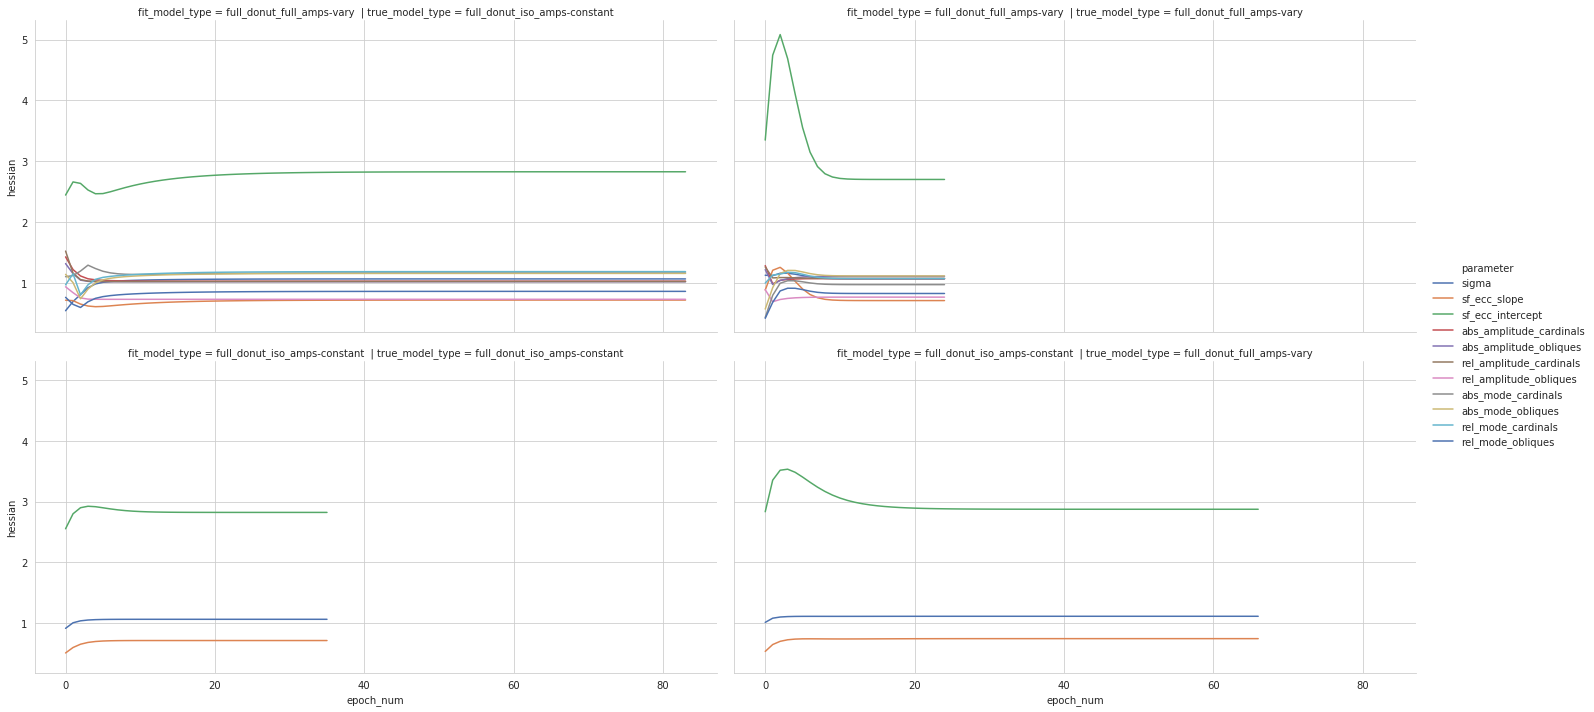

In [17]:
g=sns.relplot('epoch_num', 'hessian', 'parameter', row='fit_model_type', col='true_model_type', hue_order=sfp.plotting.PARAM_ORDER,# col='batch_size', row='learning_rate', 
              data=model_history.query("learning_rate==1e-3 & batch_size==10"), kind='line', aspect=2,
              ci='sd', palette=sns.color_palette('deep', 11))#facet_kws={'sharey': False})

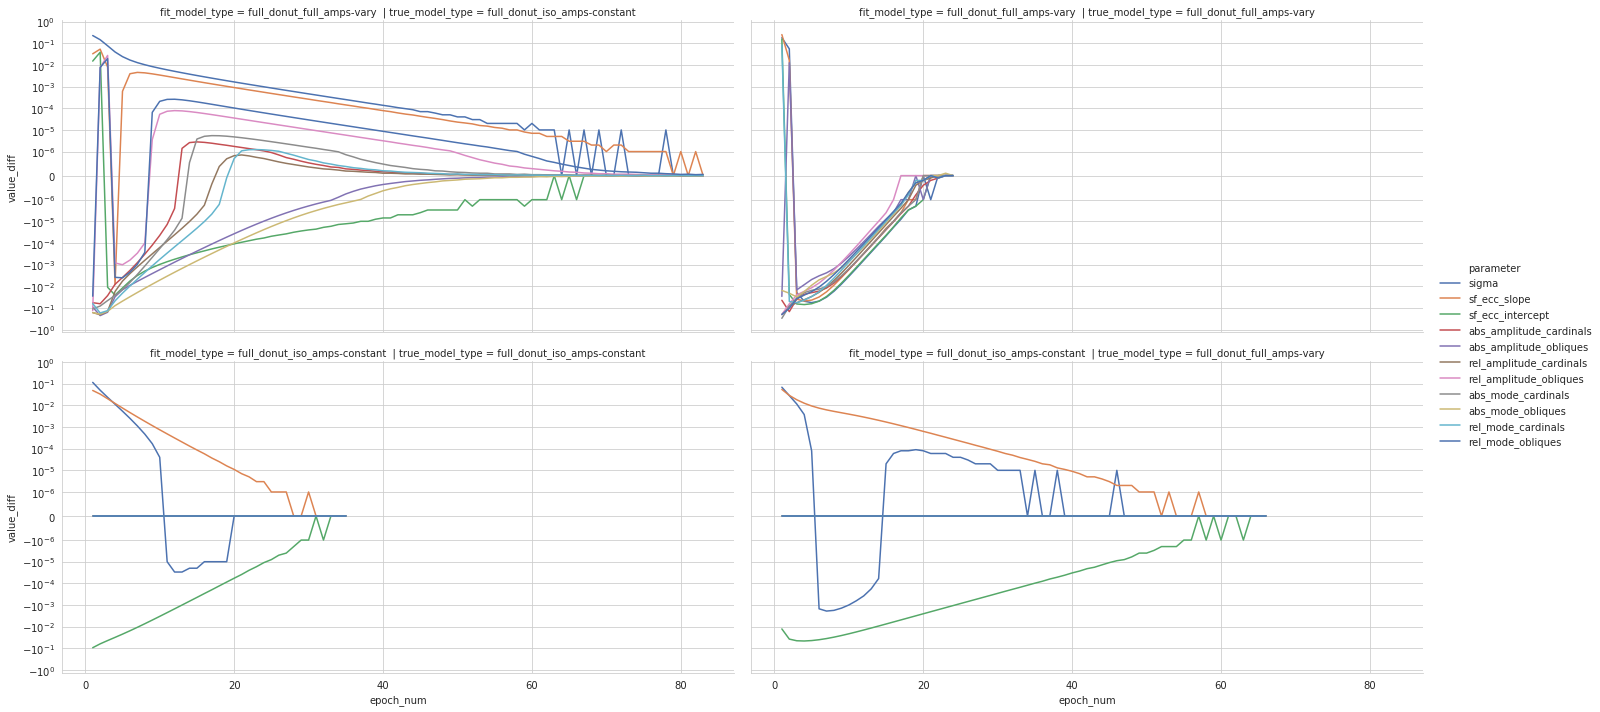

In [18]:
g=sns.relplot('epoch_num', 'value_diff', 'parameter', row='fit_model_type', col='true_model_type', hue_order=sfp.plotting.PARAM_ORDER,# col='batch_size', row='learning_rate', 
              data=model_history.query("learning_rate==1e-3 & batch_size==10"), kind='line', aspect=2,
              ci='sd', palette=sns.color_palette('deep', 11))#facet_kws={'sharey': False})
for ax in g.axes.flatten():
    ax.set_yscale('symlog', basey=10, linthreshy=1e-6)

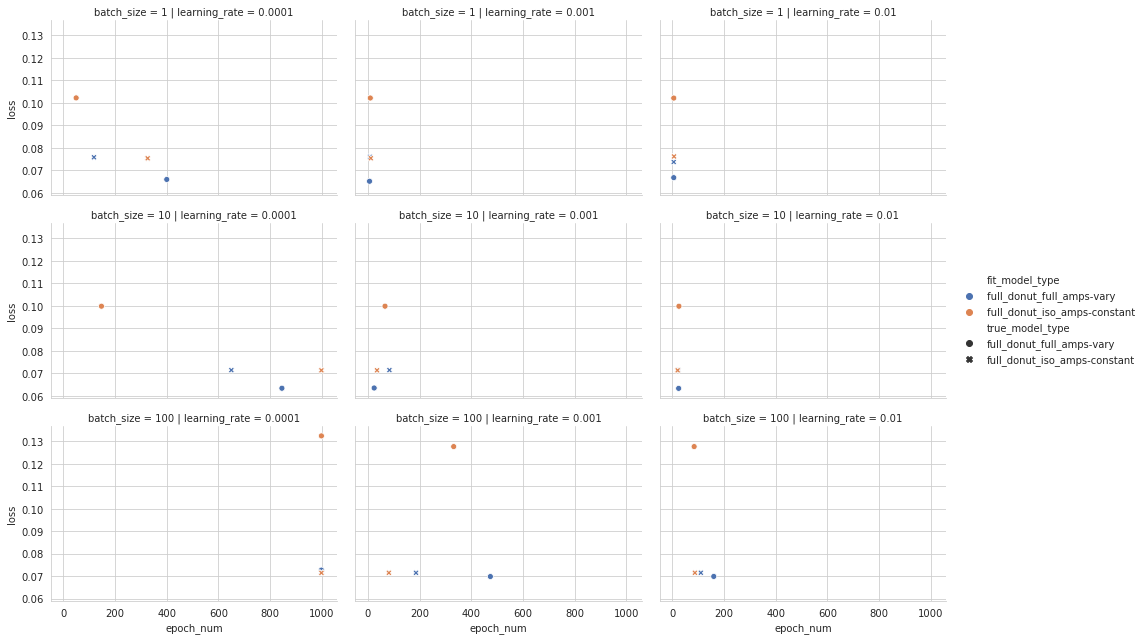

In [19]:
sns.relplot('epoch_num', 'loss', row='batch_size', col='learning_rate', data=avg_loss, hue='fit_model_type', style='true_model_type', legend='full', palette=sns.color_palette('deep', 2), aspect=1.5, height=3)

## Some simulated model recovery

In [54]:
base_str = '/mnt/prince_scratch/spatial_frequency_preferences/derivatives/tuning_2d_simulated/noise-stim_class_bayesian_posterior_sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12/model_recovery/g0_all_'
models = pd.read_csv(base_str + 'models.csv')
model_history = pd.read_csv(base_str + 'model_history.csv')
timing_df = pd.read_csv(base_str + 'timing.csv')
avg_loss = pd.read_csv(base_str + 'loss.csv')
loss_df = pd.read_csv(base_str + 'diff.csv')

In [47]:
model_order = ['constant_donut_iso_amps-constant', 'scaling_donut_iso_amps-constant', 'full_donut_iso_amps-constant',
               'full_donut_absolute_amps-constant', 'full_donut_relative_amps-constant', 'full_donut_full_amps-constant',
               'full_donut_absolute_amps-vary', 'full_donut_relative_amps-vary', 'full_donut_full_amps-vary']

In [55]:
# hack to deal with this issue, hopefully fixed soon: https://github.com/mwaskom/seaborn/issues/1560
avg_loss.true_model_type = avg_loss.true_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))
loss_df.true_model_type = loss_df.true_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))
models.true_model_type = models.true_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))
model_history.true_model_type = model_history.true_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))
timing_df.true_model_type = timing_df.true_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))

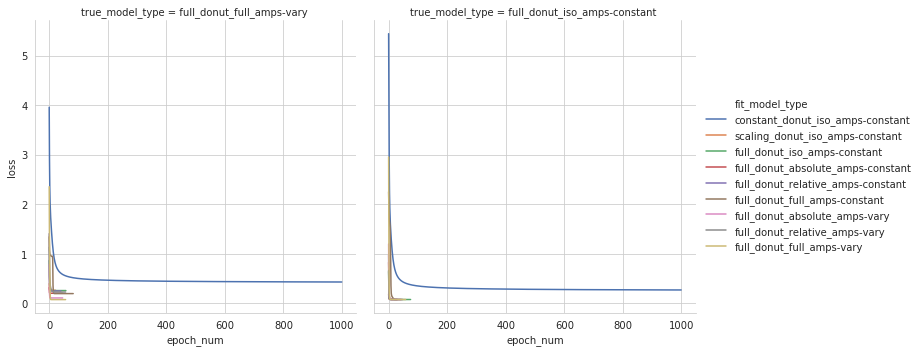

In [57]:
g = sns.relplot('epoch_num', 'loss', 'fit_model_type', col='true_model_type', data=loss_df, kind='line', ci='sd', palette=sns.color_palette('deep', 9), hue_order=model_order )
                #facet_kws={'sharey':False, 'sharex': False})
#g.set(ylim=(-.025, .05))

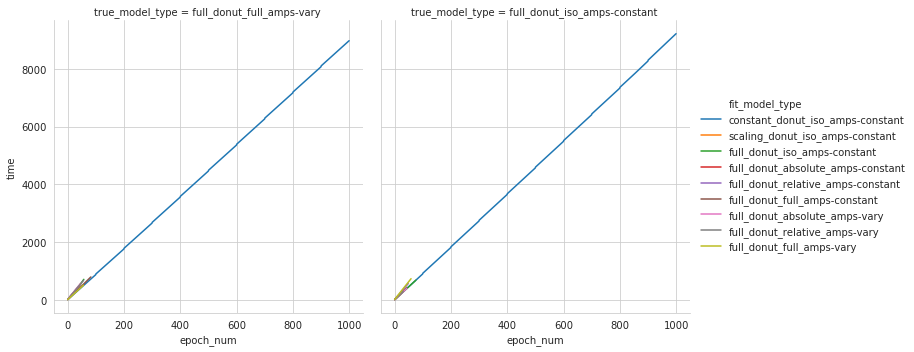

In [58]:
g=sns.relplot('epoch_num', 'time', 'fit_model_type', data=timing_df, col='true_model_type', kind='line', legend='full', hue_order=model_order)

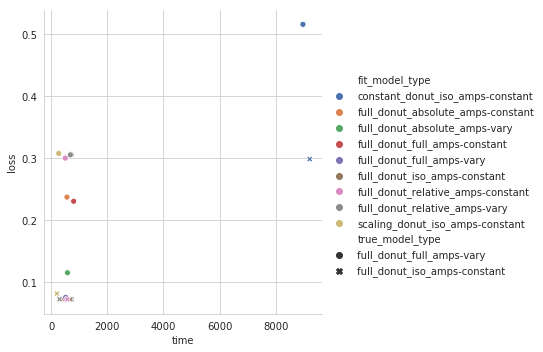

In [59]:
sns.relplot('time', 'loss', 'fit_model_type', data=avg_loss, style='true_model_type', legend='full', palette=sns.color_palette('deep', 9), )#hue_order=[i+" " for i in model_order])

In [60]:
models.pivot_table('fit_value', ['true_model_type', 'fit_model_type'], 'model_parameter')

model_parameter                                                  abs_amplitude_cardinals  \
true_model_type               fit_model_type                                               
full_donut_full_amps-vary     constant_donut_iso_amps-constant                  0.000000   
                              full_donut_absolute_amps-constant                 0.000000   
                              full_donut_absolute_amps-vary                     0.042022   
                              full_donut_full_amps-constant                     0.000000   
                              full_donut_full_amps-vary                         0.042725   
                              full_donut_iso_amps-constant                      0.000000   
                              full_donut_relative_amps-constant                 0.000000   
                              full_donut_relative_amps-vary                     0.000000   
                              scaling_donut_iso_amps-constant                   0.000000   
full_donut_iso_amps-constant  constant_donut_iso_amps-constant                  0.000000   
                              full_donut_absolute_amps-constant                 0.000000   
                              full_donut_absolute_amps-vary                     0.001197   
                              full_donut_full_amps-constant                     0.000000   
                              full_donut_full_amps-vary                         0.000700   
                              full_donut_iso_amps-constant                      0.000000   
                              full_donut_relative_amps-constant                 0.000000   
                              full_donut_relative_amps-vary                     0.000000   
                              scaling_donut_iso_amps-constant                   0.000000   

model_parameter                                                  abs_amplitude_obliques  \
true_model_type               fit_model_type                                              
full_donut_full_amps-vary     constant_donut_iso_amps-constant                 0.000000   
                              full_donut_absolute_amps-constant                0.000000   
                              full_donut_absolute_amps-vary                    0.287259   
                              full_donut_full_amps-constant                    0.000000   
                              full_donut_full_amps-vary                        0.299020   
                              full_donut_iso_amps-constant                     0.000000   
                              full_donut_relative_amps-constant                0.000000   
                              full_donut_relative_amps-vary                    0.000000   
                              scaling_donut_iso_amps-constant                  0.000000   
full_donut_iso_amps-constant  constant_donut_iso_amps-constant                 0.000000   
                              full_donut_absolute_amps-constant                0.000000   
                              full_donut_absolute_amps-vary                    0.000379   
                              full_donut_full_amps-constant                    0.000000   
                              full_donut_full_amps-vary                        0.000678   
                              full_donut_iso_amps-constant                     0.000000   
                              full_donut_relative_amps-constant                0.000000   
                              full_donut_relative_amps-vary                    0.000000   
                              scaling_donut_iso_amps-constant                  0.000000   

model_parameter                                                  abs_mode_cardinals  \
true_model_type               fit_model_type                                          
full_donut_full_amps-vary     constant_donut_iso_amps-constant             0.000000   
                              full_donut_absolute_amps-constant            0.

In [61]:
models.pivot_table('true_value', ['true_model_type'], 'model_parameter')

model_parameter                abs_amplitude_cardinals  \
true_model_type                                          
full_donut_full_amps-vary                         0.04   
full_donut_iso_amps-constant                      0.00   

model_parameter                abs_amplitude_obliques  abs_mode_cardinals  \
true_model_type                                                             
full_donut_full_amps-vary                         0.3                 0.2   
full_donut_iso_amps-constant                      0.0                 0.0   

model_parameter                abs_mode_obliques  rel_amplitude_cardinals  \
true_model_type                                                             
full_donut_full_amps-vary                   0.05                     0.03   
full_donut_iso_amps-constant                0.00                     0.00   

model_parameter                rel_amplitude_obliques  rel_mode_cardinals  \
true_model_type                                                             
full_donut_full_amps-vary                         0.1                 0.1   
full_donut_iso_amps-constant                      0.0                 0.0   

model_parameter                rel_mode_obliques  sf_ecc_intercept  \
true_model_type                                                      
full_donut_full_amps-vary                   0.05              0.25   
full_donut_iso_amps-constant                0.00              0.25   

model_parameter                sf_ecc_slope  sigma  
true_model_type                                     
full_donut_full_amps-vary              0.75    1.0  
full_donut_iso_amps-constant           0.75    1.0

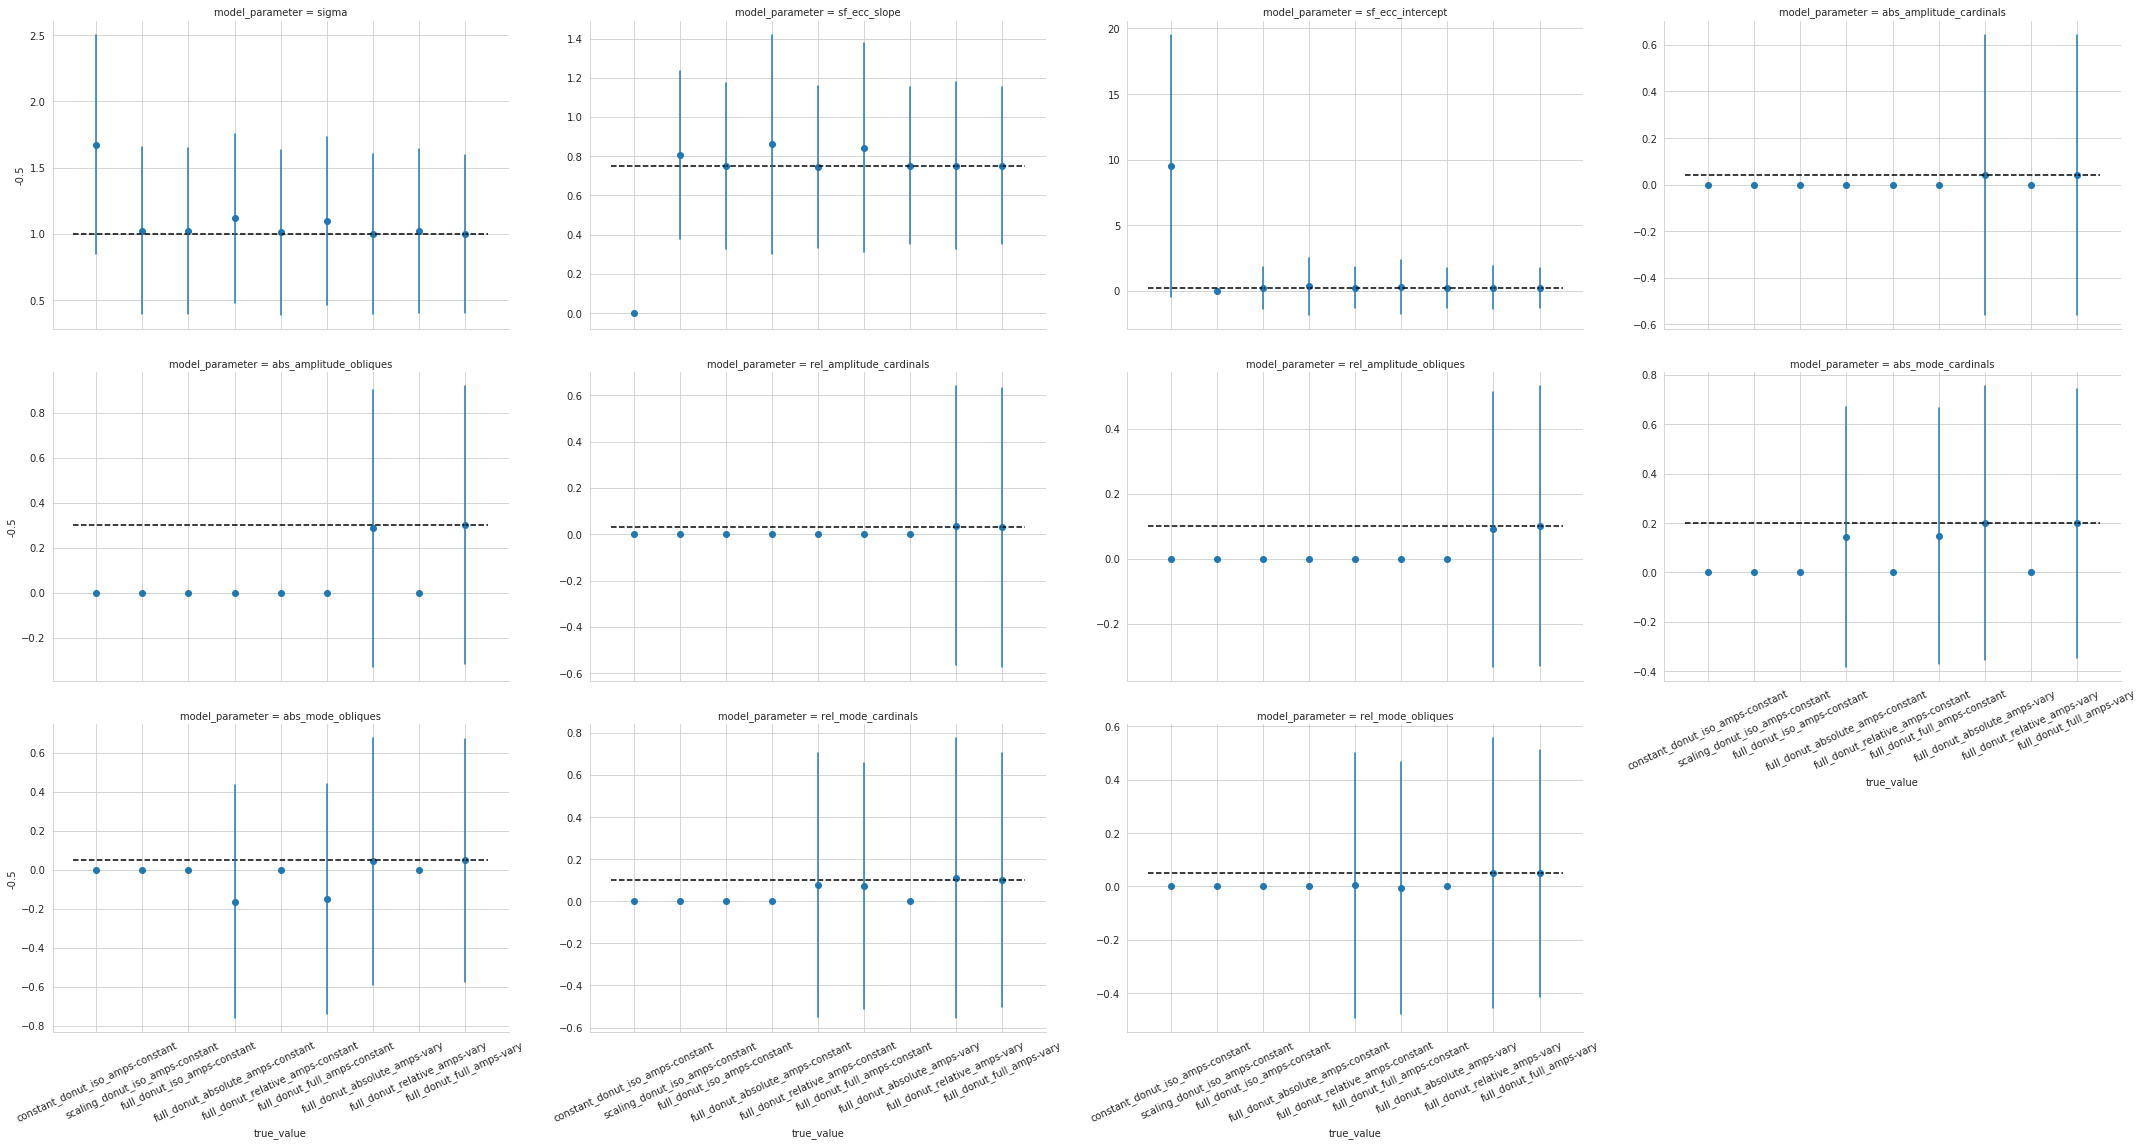

In [63]:
param_col_order = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']
param_col_order.extend(['%s_%s_%s' % (i, j ,k) for j, i, k in itertools.product(['amplitude', 'mode'], ['abs', 'rel'], ['cardinals', 'obliques'])])

def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.FacetGrid(data=models.query('true_model_type=="full_donut_full_amps-vary "'), col='model_parameter',
                  palette=sns.color_palette('deep', 9), col_wrap=4, col_order=param_col_order, height=5, aspect=1.5, sharey=False)
g.map_dataframe(sfp.plotting.scatter_ci_col, 'fit_model_type', 'fit_value', 'hessian', x_order=model_order)
g.map_dataframe(custom_hline, 'true_value', -.5, 8.5, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)

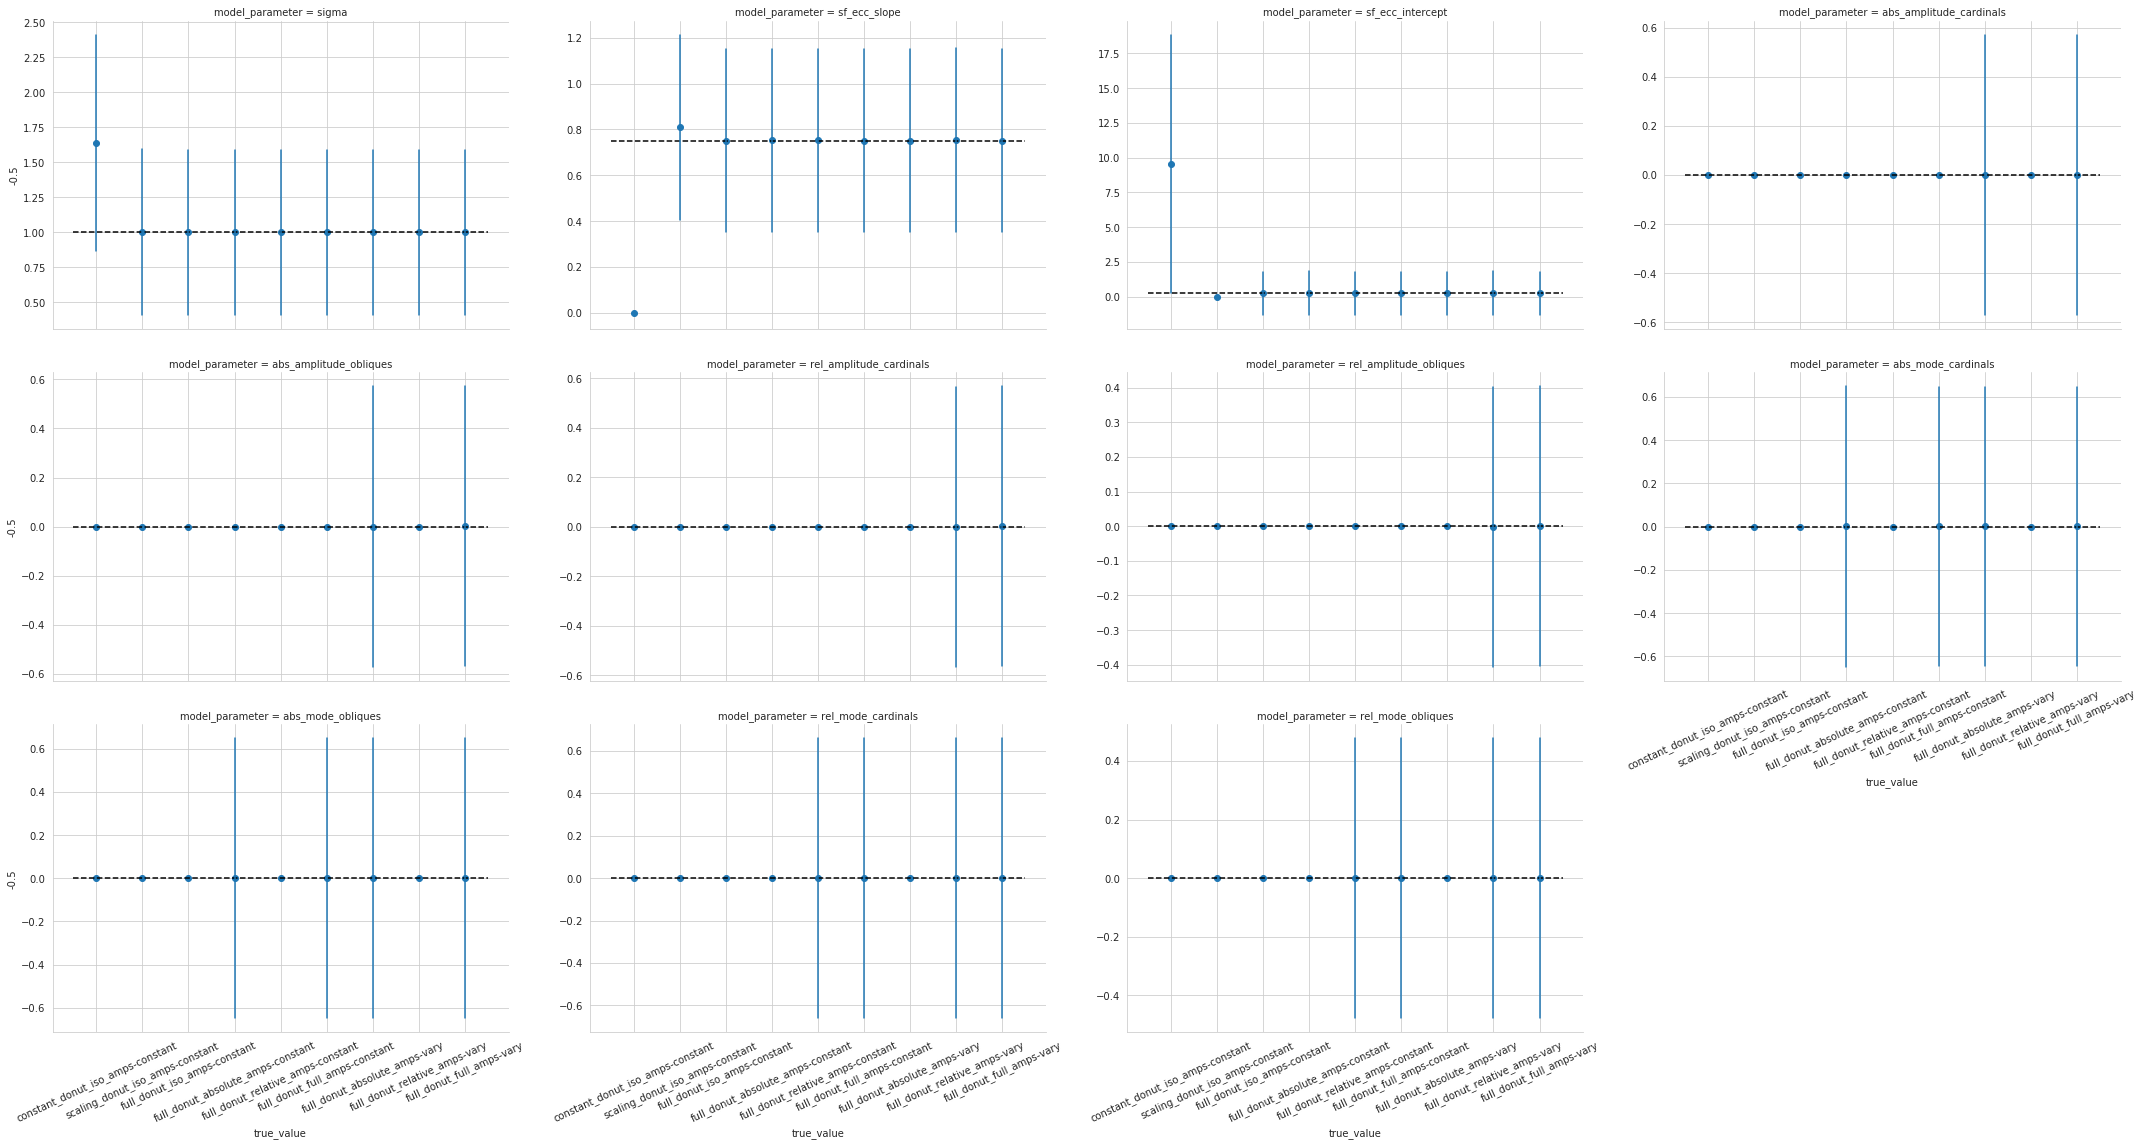

In [64]:
param_col_order = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']
param_col_order.extend(['%s_%s_%s' % (i, j ,k) for j, i, k in itertools.product(['amplitude', 'mode'], ['abs', 'rel'], ['cardinals', 'obliques'])])

def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.FacetGrid(data=models.query('true_model_type=="full_donut_iso_amps-constant "'), col='model_parameter',
                  palette=sns.color_palette('deep', 9), col_wrap=4, col_order=param_col_order, height=5, aspect=1.5, sharey=False)
g.map_dataframe(sfp.plotting.scatter_ci_col, 'fit_model_type', 'fit_value', 'hessian', x_order=model_order)
g.map_dataframe(custom_hline, 'true_value', -.5, 8.5, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)

## Some simulated cross-validated model recovery

In [4]:
base_str = '/users/broderick/mnt/prince_scratch/spatial_frequency_preferences/derivatives/tuning_2d_simulated/noise-stim_class_bayesian_posterior_sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12/model_recovery_cv/b10_r.001_g0_s0_all_'
models = pd.read_csv(base_str + 'models.csv')
timing_df = pd.read_csv(base_str + 'timing.csv')
avg_loss = pd.read_csv(base_str + 'loss.csv')
cv_loss = pd.read_csv(base_str + 'cv_loss.csv')

In [5]:
model_order = ['constant_donut_iso_amps-constant', 'scaling_donut_iso_amps-constant', 'full_donut_iso_amps-constant',
               'full_donut_absolute_amps-constant', 'full_donut_relative_amps-constant', 'full_donut_full_amps-constant',
               'full_donut_absolute_amps-vary', 'full_donut_relative_amps-vary', 'full_donut_full_amps-vary']

In [6]:
# hack to deal with this issue, hopefully fixed soon: https://github.com/mwaskom/seaborn/issues/1560
avg_loss.true_model_type = avg_loss.true_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))
cv_loss.true_model_type = cv_loss.true_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))
models.true_model_type = models.true_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))
timing_df.true_model_type = timing_df.true_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))

In [16]:
pd.pivot_table(cv_loss, 'cv_loss', ['true_model_type', 'fit_model_type'], ).sort_values(['true_model_type','cv_loss'])#.reindex(itertools.product(['full_donut_full_amps-vary', 'full_donut_iso_amps-constant'], model_order),)

cv_loss
true_model_type               fit_model_type                             
full_donut_full_amps-vary     full_donut_full_amps-vary          0.076134
                              full_donut_relative_amps-vary      0.118201
                              full_donut_absolute_amps-vary      0.118805
                              full_donut_absolute_amps-constant  0.120931
                              full_donut_iso_amps-constant       0.159378
                              scaling_donut_iso_amps-constant    0.164462
                              constant_donut_iso_amps-constant   0.342039
                              full_donut_full_amps-constant      0.400195
                              full_donut_relative_amps-constant  0.759471
full_donut_iso_amps-constant  full_donut_iso_amps-constant       0.075958
                              full_donut_absolute_amps-constant  0.075965
                              full_donut_absolute_amps-vary      0.075966
                              full_donut_full_amps-vary          0.075972
                              scaling_donut_iso_amps-constant    0.081527
                              full_donut_full_amps-constant      0.164600
                              full_donut_relative_amps-vary      0.201027
                              constant_donut_iso_amps-constant   0.270249
                              full_donut_relative_amps-constant  0.333873

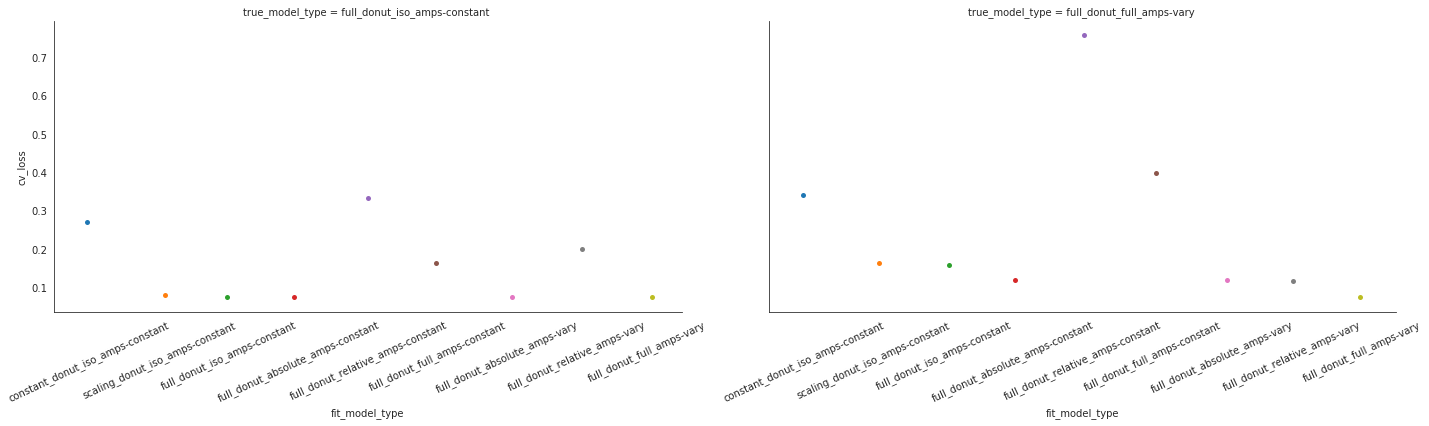

In [22]:
g = sns.catplot('fit_model_type', 'cv_loss', data=cv_loss, col='true_model_type', order=model_order, aspect=2)
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)

These plots use the hessian to show the error bars, but I think they're unreasonably large -- in the actual analysis, we'll use bootstraps.

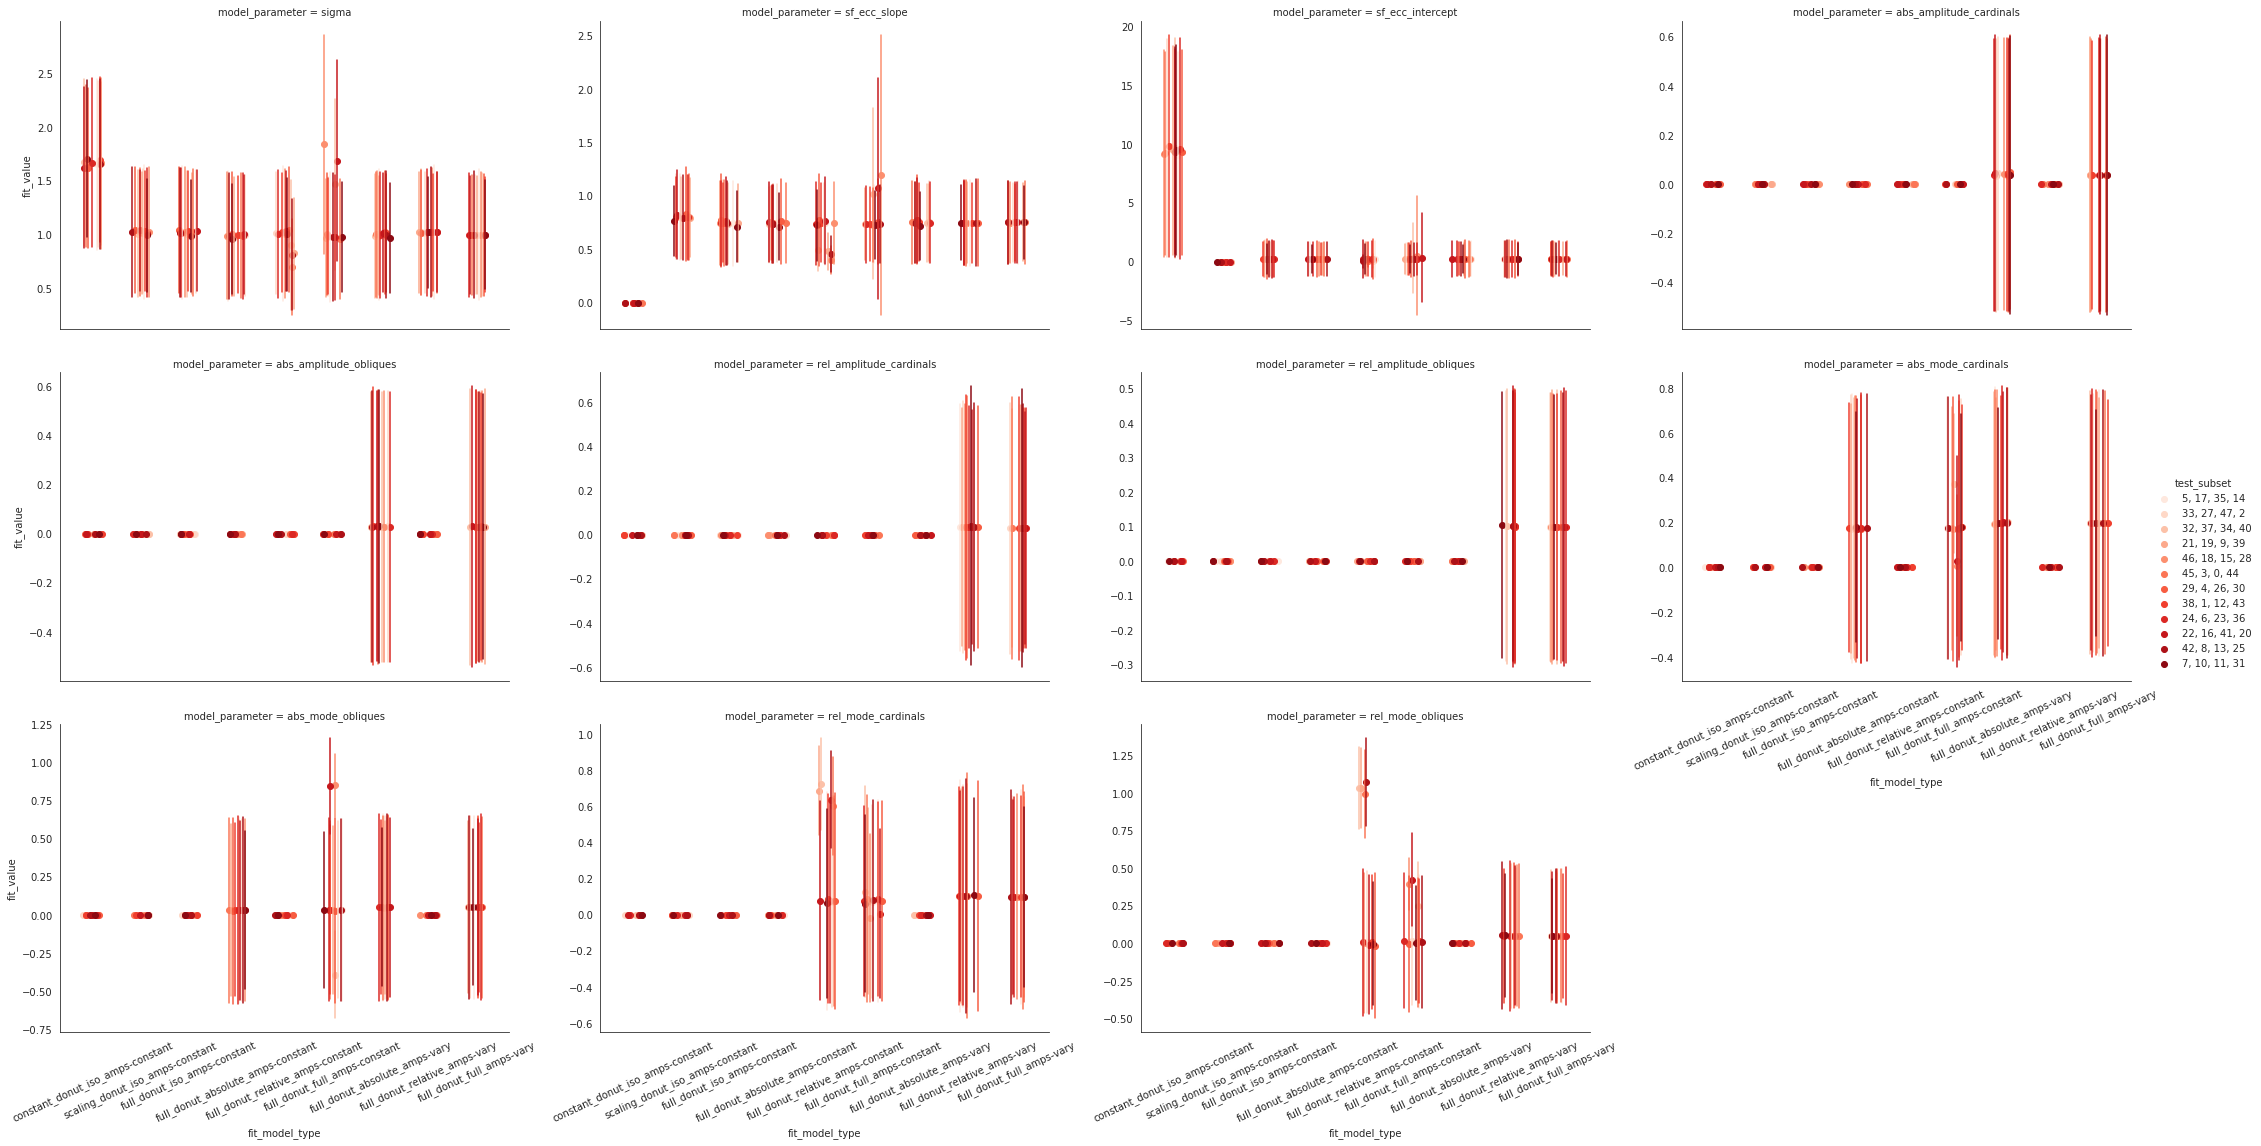

In [27]:
param_col_order = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']
param_col_order.extend(['%s_%s_%s' % (i, j ,k) for j, i, k in itertools.product(['amplitude', 'mode'], ['abs', 'rel'], ['cardinals', 'obliques'])])

def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.FacetGrid(data=models.query('true_model_type=="full_donut_full_amps-vary "'), col='model_parameter', hue='test_subset',
                  palette=sns.color_palette('Reds', 12), col_wrap=4, col_order=param_col_order, height=5, aspect=1.5, sharey=False)
g.map_dataframe(sfp.plotting.scatter_ci_col, 'fit_model_type', 'fit_value', 'hessian', x_order=model_order, x_jitter=.2)
# g.map_dataframe(custom_hline, 'true_value', -.5, 8.5, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)
g.add_legend()

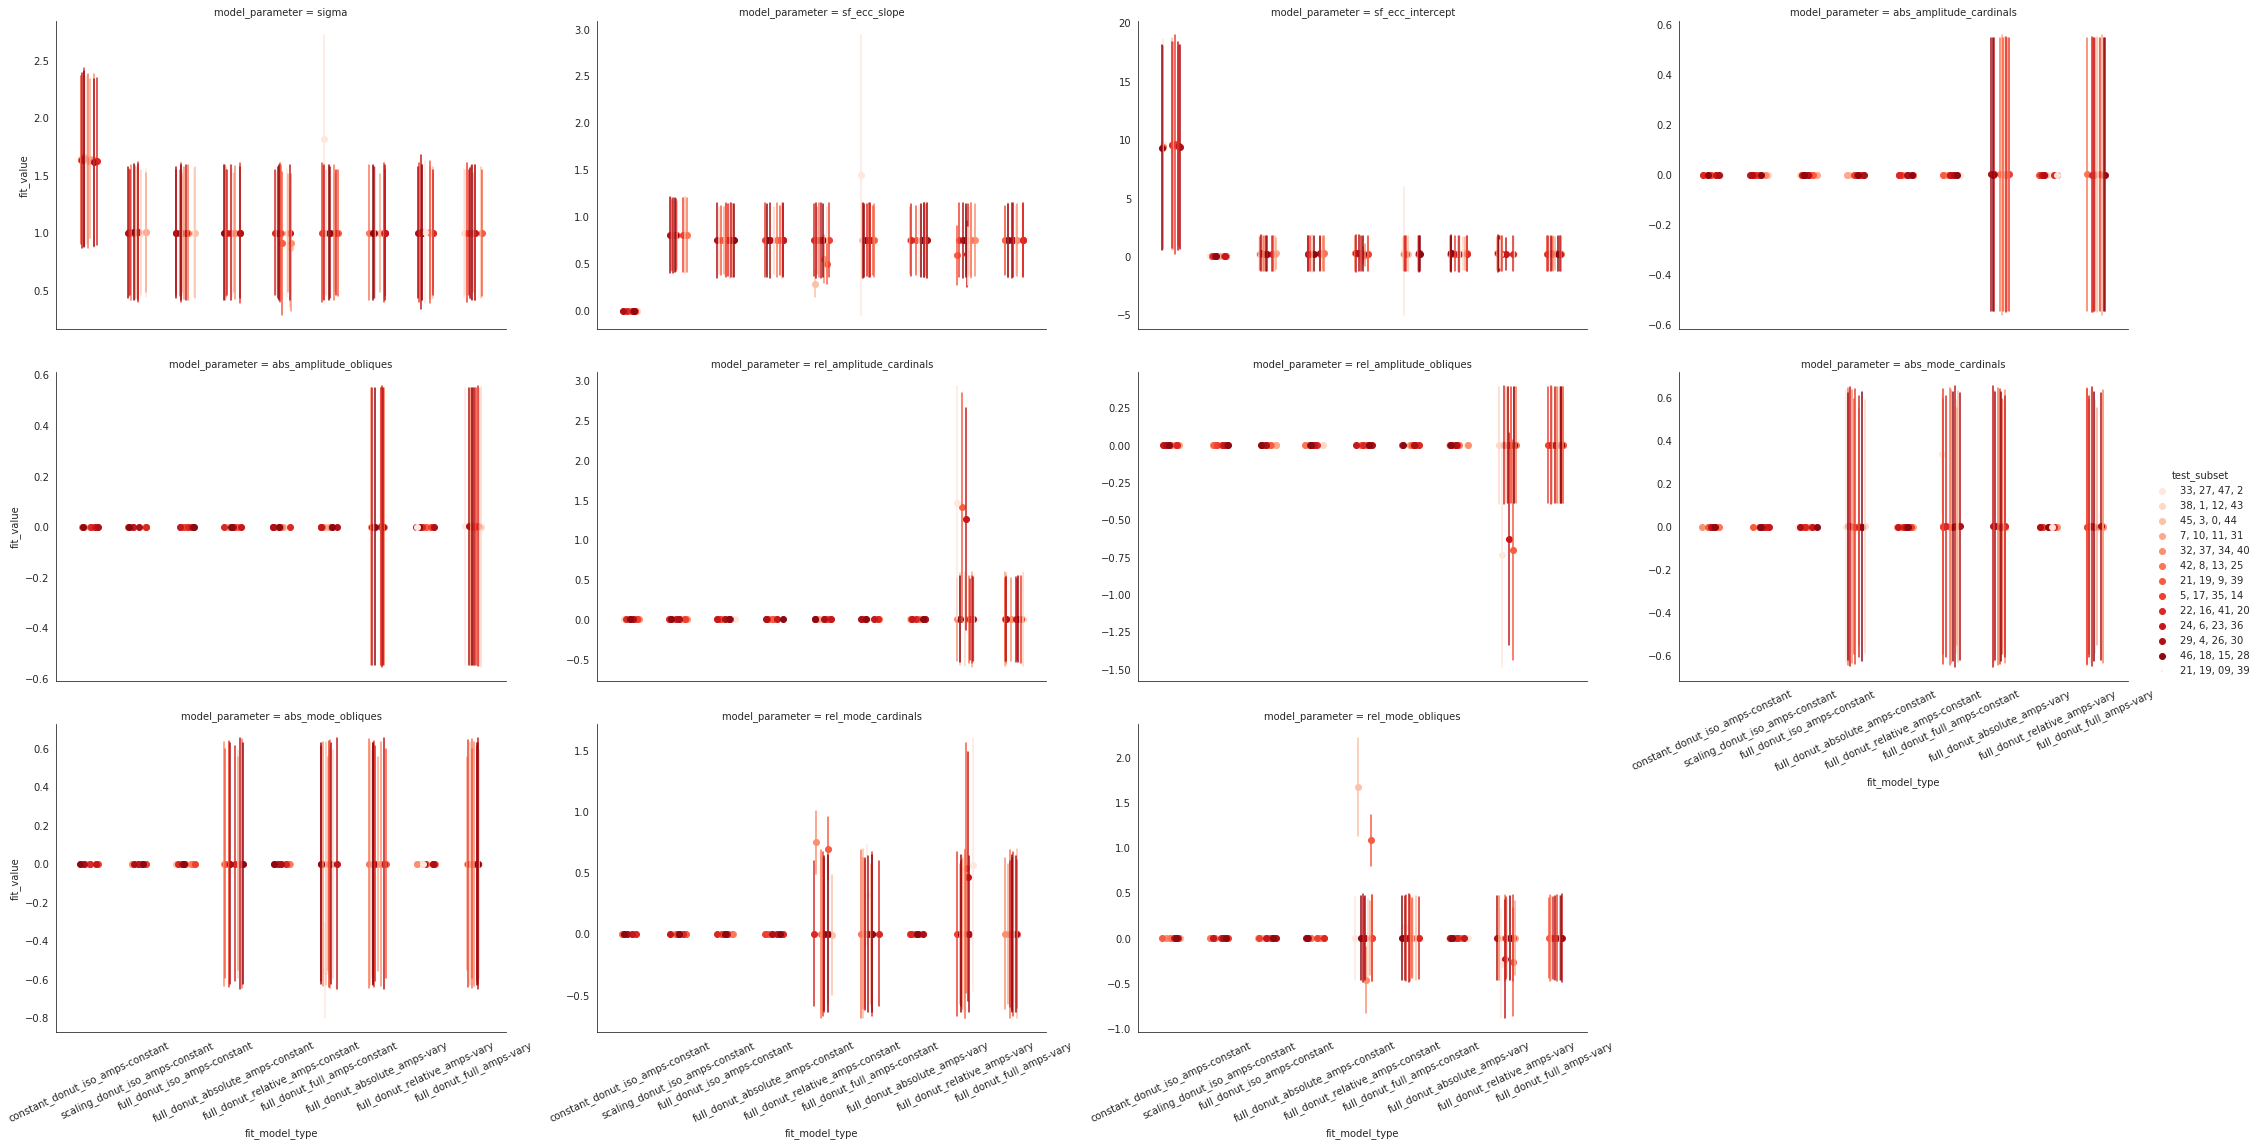

In [34]:
param_col_order = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']
param_col_order.extend(['%s_%s_%s' % (i, j ,k) for j, i, k in itertools.product(['amplitude', 'mode'], ['abs', 'rel'], ['cardinals', 'obliques'])])

def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.FacetGrid(data=models.query('true_model_type=="full_donut_iso_amps-constant "'), col='model_parameter', hue='test_subset',
                  palette=sns.color_palette('Reds', 12), col_wrap=4, col_order=param_col_order, height=5, aspect=1.5, sharey=False)
g.map_dataframe(sfp.plotting.scatter_ci_col, 'fit_model_type', 'fit_value', 'hessian', x_order=model_order, x_jitter=.2)
#g.map_dataframe(custom_hline, 'true_value', -.5, 8.5, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)
g.add_legend()

## Looking at subjects' cross-validated model fits

### Across subjects and sessions

Now we look at all the cross-validated fits to subjects and sessions, using the pre-shrunk data computed by the snakemake rule `summarize_model_cv` (because the files are too big to hold all in memory).

In [10]:
base_str = '/users/broderick/mnt/prince_scratch/spatial_frequency_preferences/derivatives/tuning_2d_model/stim_class/bayesian_posterior/initial_cv/v1_e1-12_summary_b10_r0.001_g0_s0_all_'
models = pd.read_csv(base_str + 'models.csv')
timing_df = pd.read_csv(base_str + 'timing.csv')
avg_loss = pd.read_csv(base_str + 'loss.csv')
cv_loss = pd.read_csv(base_str + 'cv_loss.csv')

In [11]:
model_order = ['constant_donut_iso_amps-constant', 'scaling_donut_iso_amps-constant', 'full_donut_iso_amps-constant',
               'full_donut_absolute_amps-constant', 'full_donut_relative_amps-constant', 'full_donut_full_amps-constant',
               'full_donut_absolute_amps-vary', 'full_donut_relative_amps-vary', 'full_donut_full_amps-vary']

In [12]:
avg_loss['indicator'] = avg_loss.apply(lambda x: str((x.subject, x.session)), 1)
models['indicator'] = models.apply(lambda x: str((x.subject, x.session)), 1)
cv_loss['indicator'] = cv_loss.apply(lambda x: str((x.subject, x.session)), 1)
timing_df['indicator'] = timing_df.apply(lambda x: str((x.subject, x.session)), 1)
indicator_order = cv_loss.indicator.unique()

In [13]:
pd.pivot_table(cv_loss, 'cv_loss', ['fit_model_type'], 'indicator')

indicator                          ('sub-wlsubj001', 'ses-01')  \
fit_model_type                                                   
constant_donut_iso_amps-constant                      0.068717   
full_donut_absolute_amps-constant                     0.067821   
full_donut_absolute_amps-vary                         0.067751   
full_donut_full_amps-constant                         0.067308   
full_donut_full_amps-vary                             0.067058   
full_donut_iso_amps-constant                          0.067805   
full_donut_relative_amps-constant                     0.067311   
full_donut_relative_amps-vary                         0.067213   
scaling_donut_iso_amps-constant                       0.069321   

indicator                          ('sub-wlsubj001', 'ses-02')  \
fit_model_type                                                   
constant_donut_iso_amps-constant                      0.123048   
full_donut_absolute_amps-constant                     0.120581   
full_donut_absolute_amps-vary                         0.118788   
full_donut_full_amps-constant                         0.120594   
full_donut_full_amps-vary                             0.117534   
full_donut_iso_amps-constant                          0.120670   
full_donut_relative_amps-constant                     0.120621   
full_donut_relative_amps-vary                         0.119807   
scaling_donut_iso_amps-constant                       0.121727   

indicator                          ('sub-wlsubj001', 'ses-pilot01')  \
fit_model_type                                                        
constant_donut_iso_amps-constant                           0.104922   
full_donut_absolute_amps-constant                          0.104491   
full_donut_absolute_amps-vary                              0.104337   
full_donut_full_amps-constant                              0.104564   
full_donut_full_amps-vary                                  0.103935   
full_donut_iso_amps-constant                               0.104507   
full_donut_relative_amps-constant                          0.104531   
full_donut_relative_amps-vary                              0.104188   
scaling_donut_iso_amps-constant                            0.105561   

indicator                          ('sub-wlsubj004', 'ses-03')  \
fit_model_type                                                   
constant_donut_iso_amps-constant                      0.128973   
full_donut_absolute_amps-constant                     0.128210   
full_donut_absolute_amps-vary                         0.127948   
full_donut_full_amps-constant                         0.128318   
full_donut_full_amps-vary                             0.126982   
full_donut_iso_amps-constant                          0.128061   
full_donut_relative_amps-constant                     0.128158   
full_donut_relative_amps-vary                         0.127352   
scaling_donut_iso_amps-constant                       0.130528   

indicator                          ('sub-wlsubj007', 'ses-04')  \
fit_model_type                                                   
constant_donut_iso_amps-constant                      0.116044   
full_donut_absolute_amps-constant                     0.111762   
full_donut_absolute_amps-vary                         0.111597   
full_donut_full_amps-constant                         0.111001   
full_donut_full_amps-vary                             0.110353   
full_donut_iso_amps-constant                          0.111991   
full_donut_relative_amps-constant                     0.111238   
full_donut_relative_amps-vary                         0.110583   
scaling_donut_iso_amps-constant                       0.115787   

indicator                          ('sub-wlsubj014', 'ses-03')  \
fit_model_type                                                   
constant_donut_iso_amps-constant                      0.059773   
full_donut_absolute_amps-constant                     0.053492   
full_donut_absolute_amps-vary                 

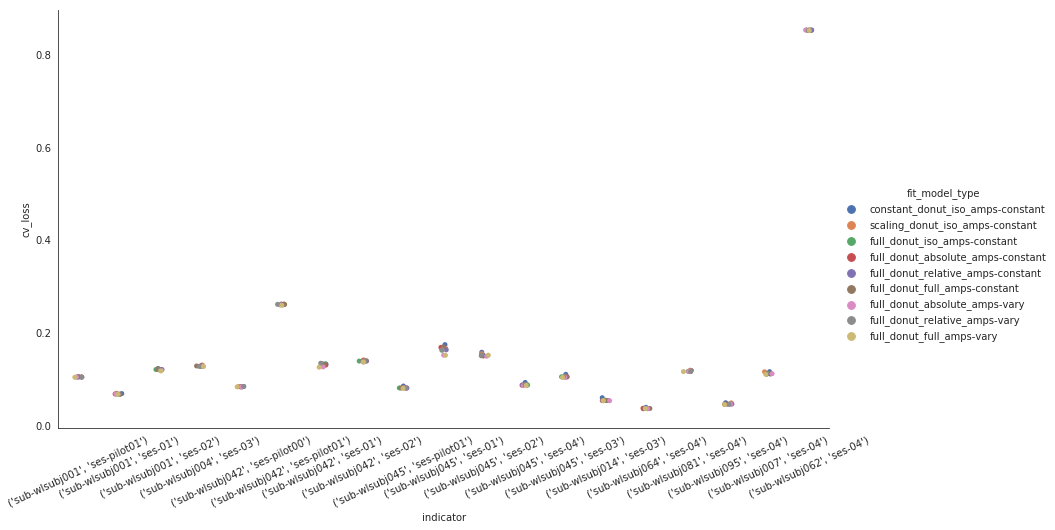

In [14]:
g = sns.catplot('indicator', 'cv_loss', 'fit_model_type', data=cv_loss, hue_order=model_order,
                legend='full', height=8, aspect=1.5, order=indicator_order, palette=sns.color_palette('deep', 9), )
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)
#g.set(ylim=(0, .15))
g.fig.subplots_adjust(bottom=.25)

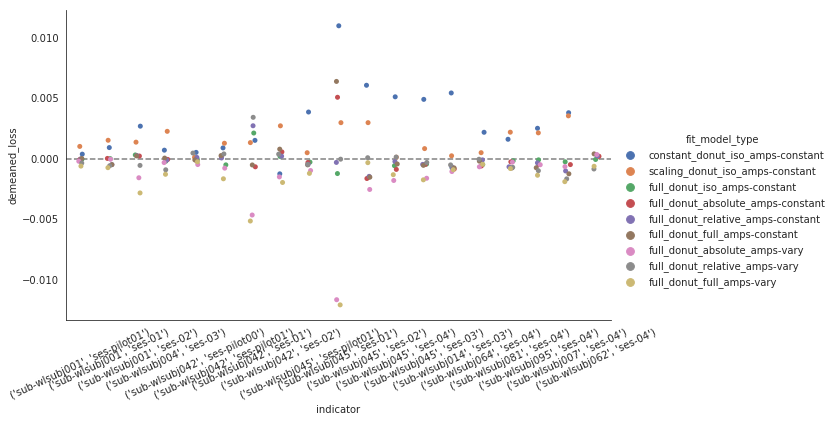

In [15]:
demeaned_loss = cv_loss.set_index(['indicator'])
demeaned_loss['loss_mean'] = cv_loss.groupby(['indicator']).cv_loss.mean()
demeaned_loss['demeaned_loss'] = (demeaned_loss.cv_loss - demeaned_loss.loss_mean)# / demeaned_all_loss.loss_mean
demeaned_loss = demeaned_loss.reset_index()

g = sns.catplot('indicator', 'demeaned_loss', 'fit_model_type', data=demeaned_loss, hue_order=model_order,
                legend='full', height=6, aspect=1.5, order=indicator_order, palette=sns.color_palette('deep', 9),)
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)
    ax.axhline(color='grey', linestyle='dashed')
#g.set(ylim=(-.005, .01))
g.fig.subplots_adjust(bottom=.25)

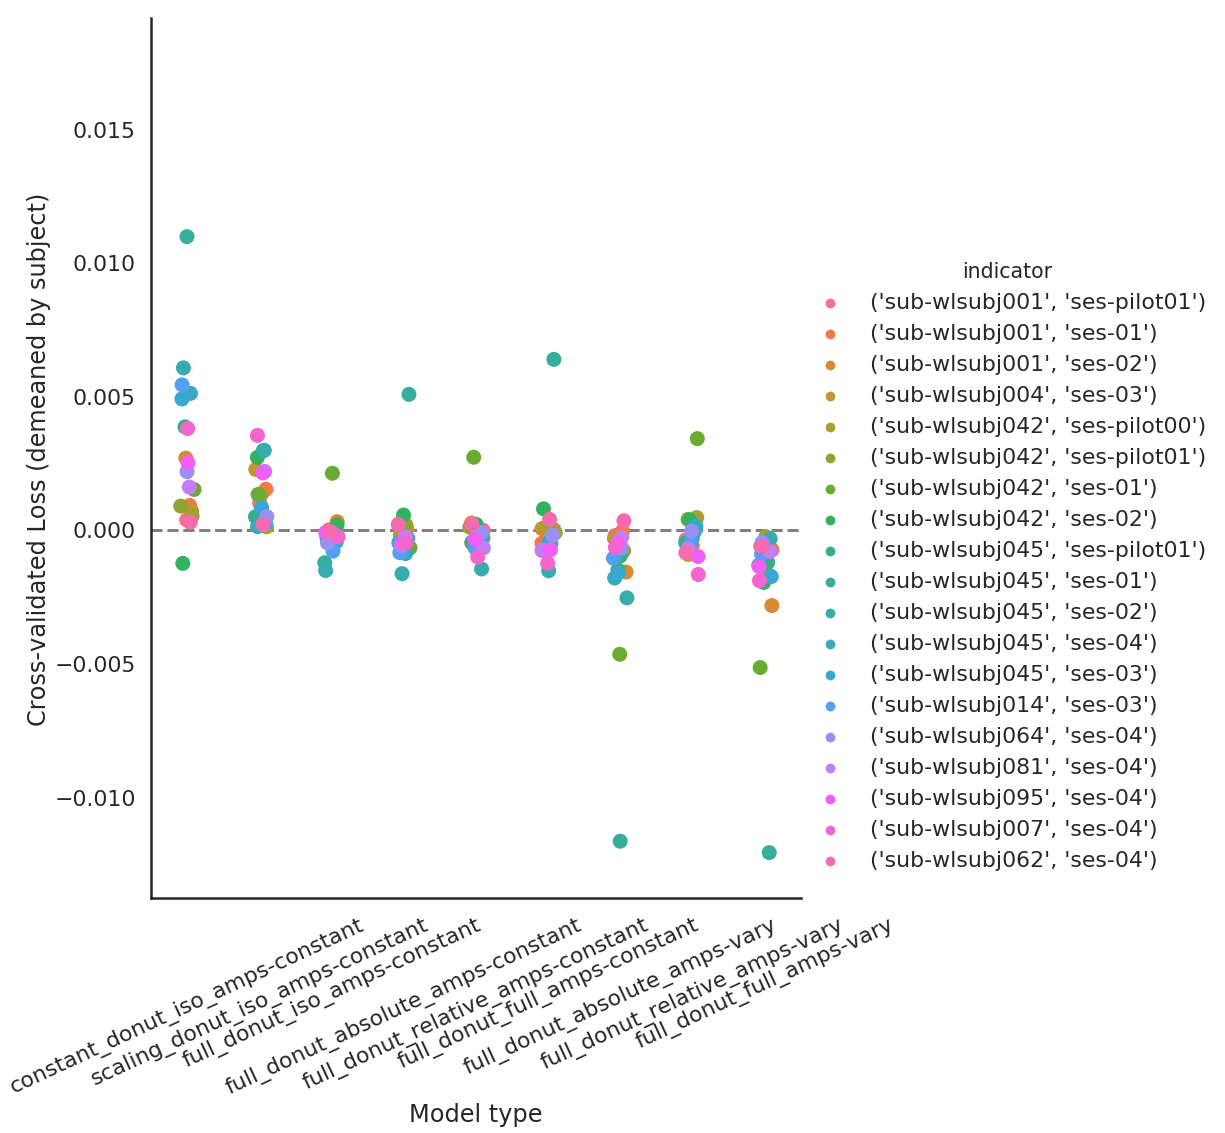

In [16]:
with sns.plotting_context('poster'), sns.color_palette('husl', demeaned_loss.indicator.nunique()):
    g = sns.catplot('fit_model_type', 'demeaned_loss', 'indicator', data=demeaned_loss, s=15,
                    legend='full', height=17, aspect=.75, kind='strip', ci=95, estimator=np.median, order=model_order)
    for ax in g.axes.flatten():
        labels = ax.get_xticklabels()
        if labels:
            ax.set_xticklabels(labels, rotation=25)
        ax.axhline(color='grey', linestyle='dashed')
    # g.set(ylim=(-.002, .006))
    g.fig.subplots_adjust(bottom=.25)
    g.set(xlabel='Model type', ylabel='Cross-validated Loss (demeaned by subject)')
    #g.fig.savefig('cv_loss_by_type.svg')

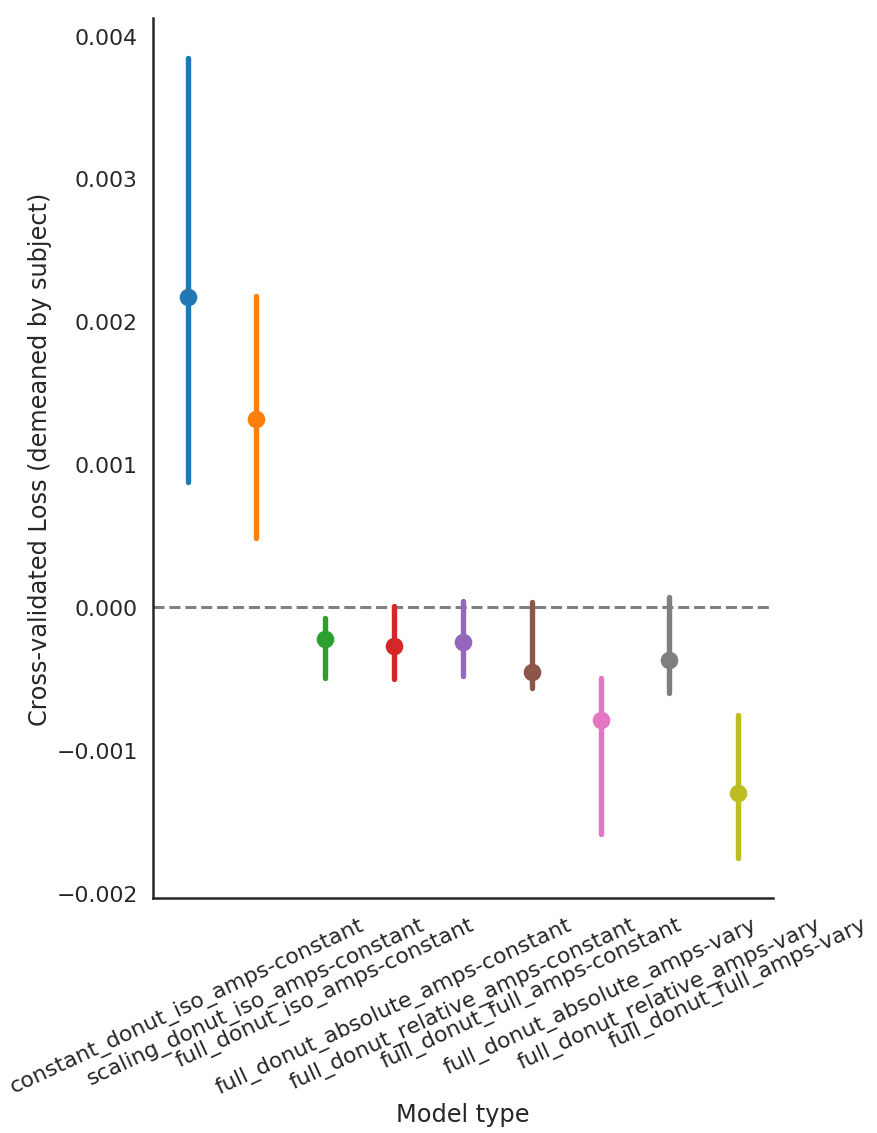

In [17]:
with sns.plotting_context('poster'):
    g = sns.catplot('fit_model_type', 'demeaned_loss', 'fit_model_type', data=demeaned_loss, s=15,
                    legend='full', height=17, aspect=.75, kind='point', ci=95, estimator=np.median, order=model_order, hue_order=model_order)
    for ax in g.axes.flatten():
        labels = ax.get_xticklabels()
        if labels:
            ax.set_xticklabels(labels, rotation=25)
        ax.axhline(color='grey', linestyle='dashed')
    # g.set(ylim=(-.002, .006))
    g.fig.subplots_adjust(bottom=.25)
    g.set(xlabel='Model type', ylabel='Cross-validated Loss (demeaned by subject)')
    #g.fig.savefig('cv_loss_by_type.svg')

### Full model fits (and bootstraps)

For these, the model has been fit to all data for a given subject (no cross-validation). We'll only look at the best one, full_donut_full_amps-vary.

We also fit models to the 100 bootstraps we have, in order to get a sense for the error bars on the model parameters.

In [32]:
models = pd.read_csv('/users/broderick/mnt/prince_scratch/spatial_frequency_preferences/derivatives/tuning_2d_model/stim_class/bayesian_posterior/initial/v1_e1-12_summary_b10_r0.001_g0_full_full_vary_all_models.csv')
bootstrap_models = pd.read_csv('/users/broderick/mnt/prince_scratch/spatial_frequency_preferences/derivatives/tuning_2d_model/stim_class/bayesian_posterior/bootstrap/v1_e1-12_full_b10_r0.001_g0_full_full_vary_all_models.csv')

In [4]:
indicator_order = models.indicator.unique()

In [174]:
parameters = [r'$\sigma$', r'$a$', r'$b$', r'$A_1$', r'$A_2$', r'$A_3$', r'$A_4$', r'$p_1$', r'$p_2$', r'$p_3$', r'$p_4$']
original_param_names = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept', 'abs_mode_cardinals', 'abs_mode_obliques', 'rel_mode_cardinals', 'rel_mode_obliques',
                        'abs_amplitude_cardinals', 'abs_amplitude_obliques', 'rel_amplitude_cardinals', 'rel_amplitude_obliques']
rename_params = dict((k, v) for k, v in zip(original_param_names, parameters))
models_plot = models.copy()#.query('fit_model_type==@fit_model_type')
models_plot = models_plot.set_index('model_parameter')
models_plot.loc['sigma', 'param_category'] = 'sigma'
models_plot.loc[['sf_ecc_slope', 'sf_ecc_intercept'], 'param_category'] = 'eccen'
models_plot.loc[['abs_mode_cardinals', 'abs_mode_obliques', 'rel_mode_cardinals', 'rel_mode_obliques',
                 'abs_amplitude_cardinals', 'abs_amplitude_obliques', 'rel_amplitude_cardinals', 'rel_amplitude_obliques'], 'param_category'] = 'orientation'
models_plot = models_plot.reset_index()
models_plot['model_parameter'] = models_plot.model_parameter.map(rename_params)
pal = dict(zip(models.indicator.unique(), sns.color_palette('husl', models.indicator.nunique())))

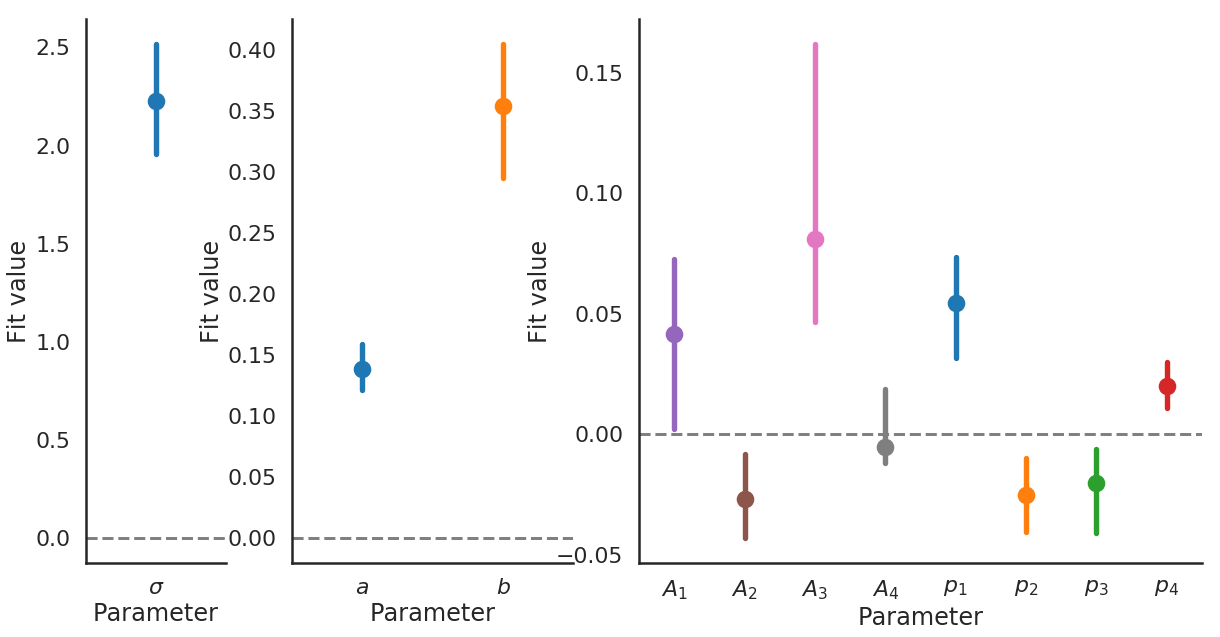

In [175]:
with sns.plotting_context('poster', font_scale=1):
    fig, axes = plt.subplots(1, 3, figsize=(20, 10), gridspec_kw={'width_ratios': [.15, .3, .6]})
    for i, ax in enumerate(axes):
        cat = ['sigma', 'eccen', 'orientation'][i]
        models_plot_order = [i for i in parameters if i in models_plot.query("param_category==@cat").model_parameter.unique()]
        sns.pointplot('model_parameter', 'fit_value', 'model_parameter', data=models_plot.query("param_category==@cat"), estimator=np.median, s=15, ax=ax, order=models_plot_order)
        if ax.legend_:
            ax.legend_.remove()
        #if i==2:
        #    ax.set(ylim=(-.25, .25))
        ax.axhline(color='grey', linestyle='dashed')
        ax.set(ylabel='Fit value', xlabel='Parameter')
    #fig.savefig('param_vals.svg')

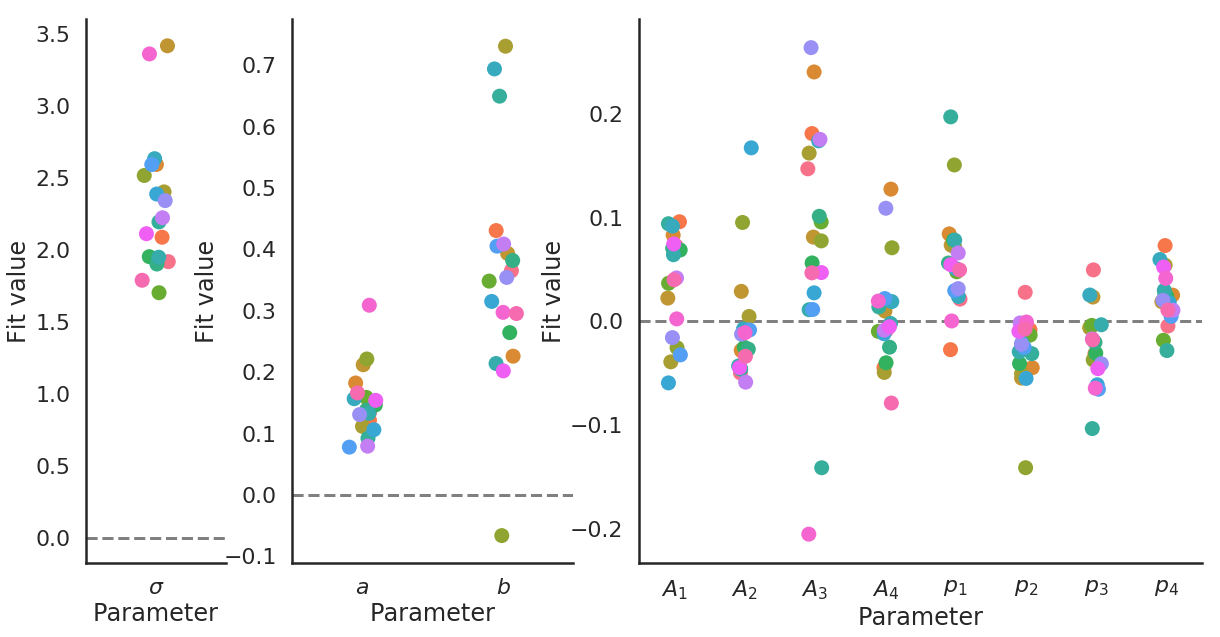

In [176]:
# models_plot = models_plot.query("session in ['ses-03', 'ses-04']")
with sns.plotting_context('poster', font_scale=1):
    fig, axes = plt.subplots(1, 3, figsize=(20, 10), gridspec_kw={'width_ratios': [.15, .3, .6]})
    for i, ax in enumerate(axes):
        cat = ['sigma', 'eccen', 'orientation'][i]
        models_plot_order = [i for i in parameters if i in models_plot.query("param_category==@cat").model_parameter.unique()]
        sns.stripplot('model_parameter', 'fit_value', 'indicator', data=models_plot.query("param_category==@cat"), s=15, ax=ax, order=models_plot_order, palette=pal)
        if ax.legend_:
            ax.legend_.remove()
        #if i==2:
        #    ax.set(ylim=(-.25, .25))
        ax.axhline(color='grey', linestyle='dashed')
        ax.set(ylabel='Fit value', xlabel='Parameter')
    #fig.savefig('param_vals.svg')

In [177]:
parameters = [r'$\sigma$', r'$a$', r'$b$', r'$p_1$', r'$p_2$', r'$p_3$', r'$p_4$', r'$A_1$', r'$A_2$', r'$A_3$', r'$A_4$']
original_param_names = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept', 'abs_mode_cardinals', 'abs_mode_obliques', 'rel_mode_cardinals', 'rel_mode_obliques',
                        'abs_amplitude_cardinals', 'abs_amplitude_obliques', 'rel_amplitude_cardinals', 'rel_amplitude_obliques']
rename_params = dict((k, v) for k, v in zip(original_param_names, parameters))
models_plot = bootstrap_models.copy()#.query('fit_model_type==@fit_model_type')
models_plot = models_plot.set_index('model_parameter')
models_plot.loc['sigma', 'param_category'] = 'sigma'
models_plot.loc[['sf_ecc_slope', 'sf_ecc_intercept'], 'param_category'] = 'eccen'
models_plot.loc[['abs_mode_cardinals', 'abs_mode_obliques', 'rel_mode_cardinals', 'rel_mode_obliques',
                 'abs_amplitude_cardinals', 'abs_amplitude_obliques', 'rel_amplitude_cardinals', 'rel_amplitude_obliques'], 'param_category'] = 'orientation'
models_plot = models_plot.reset_index()
models_plot['model_parameter'] = models_plot.model_parameter.map(rename_params)
pal = dict(zip(models.indicator.unique(), sns.color_palette('husl', models.indicator.nunique())))
#for k, v in zip(models.indicator.unique(), sns.color_palette('husl', models.indicator.nunique())):
#    pal[k] = np.expand_dims(list(v)+[1], 0)

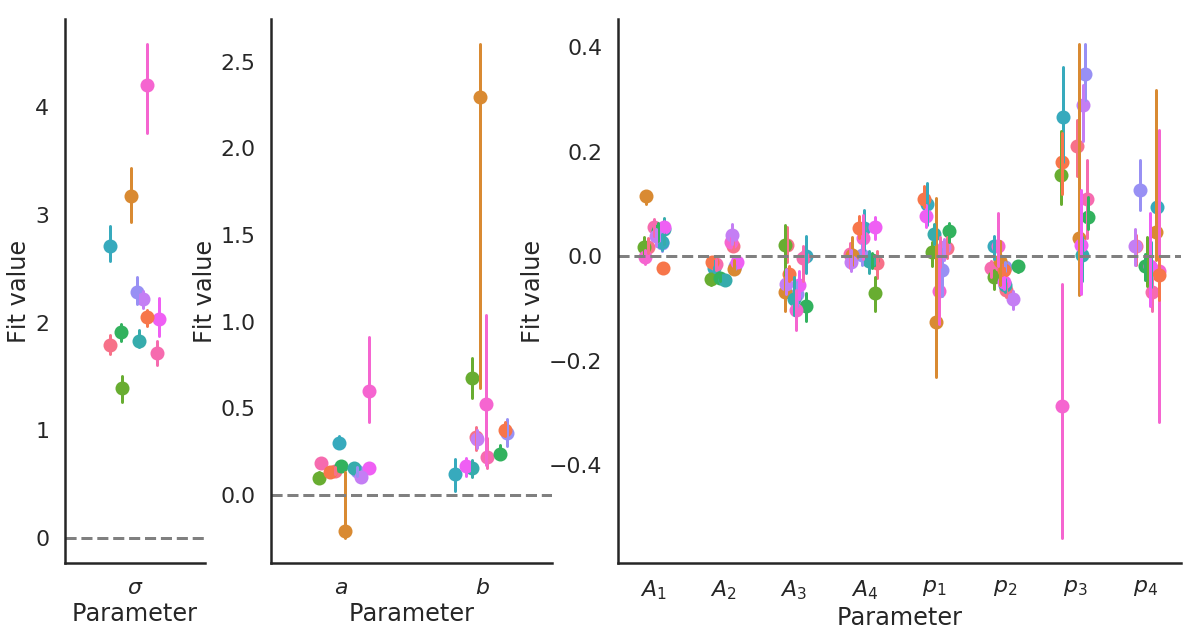

In [244]:
with sns.plotting_context('poster', font_scale=1):
    fig, axes = plt.subplots(1, 3, figsize=(20, 10), gridspec_kw={'width_ratios': [.15, .3, .6]})
    for i, ax in enumerate(axes):
        cat = ['sigma', 'eccen', 'orientation'][i]
        models_plot_order = [i for i in parameters if i in models_plot.query("param_category==@cat").model_parameter.unique()]
        for n, g in models_plot.query("param_category==@cat & session not in ['ses-pilot00', 'ses-pilot01'] & task!='task-sfpconstant'").groupby('indicator'):
            sfp.plotting.scatter_ci_dist('model_parameter', 'fit_value', data=g, label=n, ax=ax, x_jitter=.2, color=pal[n], )#x_order=models_plot_order)
        if ax.legend_:
            ax.legend_.remove()
        #if i==2:
        #    ax.set(ylim=(-.25, .25))
        ax.axhline(color='grey', linestyle='dashed')
        ax.set(ylabel='Fit value', xlabel='Parameter')
        ax.set_xlim((-.5, models_plot.query("param_category==@cat").model_parameter.nunique()-.5))
    #fig.savefig('param_vals.svg')

In [238]:
compare_df = models[['model_parameter', 'indicator', 'fit_value', 'session', 'subject', 'task']]
tmp = bootstrap_models[['model_parameter', 'indicator', 'fit_value', 'session', 'subject', 'task']].rename(columns={'fit_value': 'fit_value_bs'})
compare_df = pd.merge(tmp, compare_df, on=['model_parameter', 'indicator', 'session', 'subject', 'task'])

/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")
/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


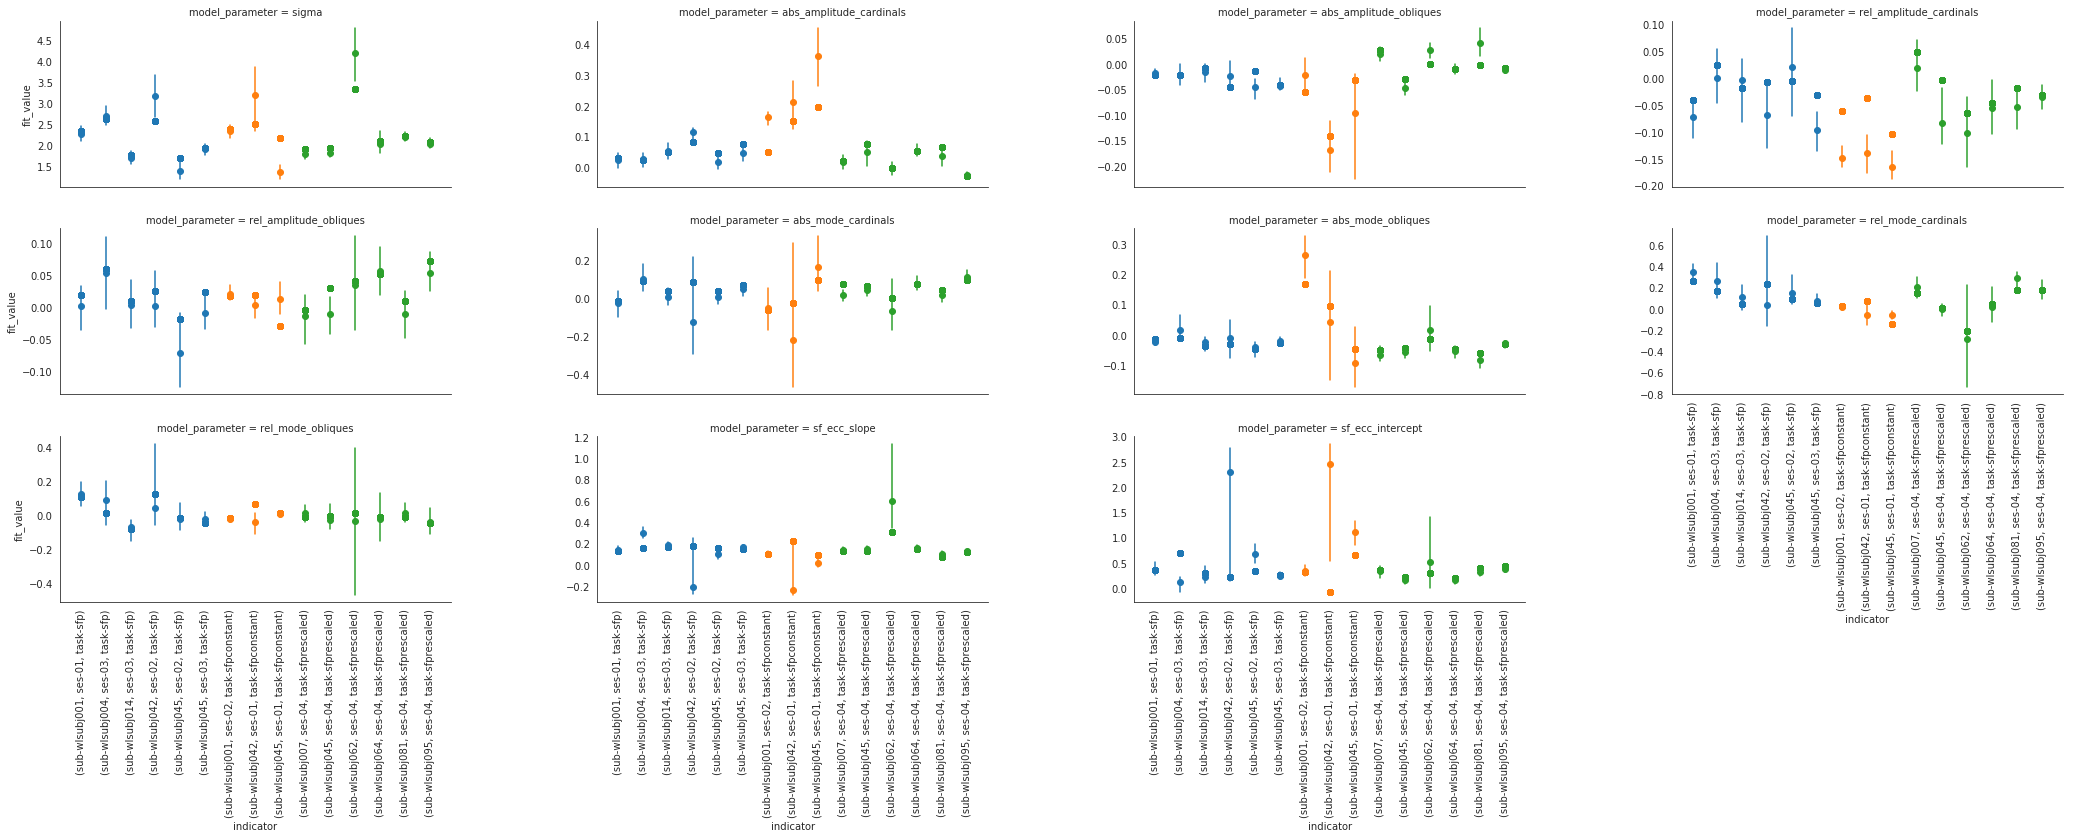

In [243]:
g = sns.FacetGrid(compare_df.query("session not in ['ses-pilot00', 'ses-pilot01']"), col='model_parameter', hue='task', col_wrap=4, sharey=False, aspect=2.5, size=3)
g.map_dataframe(sfp.plotting.scatter_ci_dist, 'indicator', 'fit_value_bs', ci_vals=[5, 95])
for ax in g.axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
g.map_dataframe(plt.scatter, 'indicator', 'fit_value')

In [374]:
feat = sfp.analyze_model.create_feature_df(models.query("fit_model_type == 'full_donut_full_amps-vary'"), reference_frame='relative')

sfp.plotting.feature_df_plot(feat, )

sfp.plotting.feature_df_plot(feat, col='indicator',)

sfp.plotting.feature_df_plot(feat, col=None, pre_boot_gb_func=np.mean)

sfp.plotting.feature_df_plot(feat, col=None)

In [253]:
feat = sfp.analyze_model.create_feature_df(models, 'preferred_period')

/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


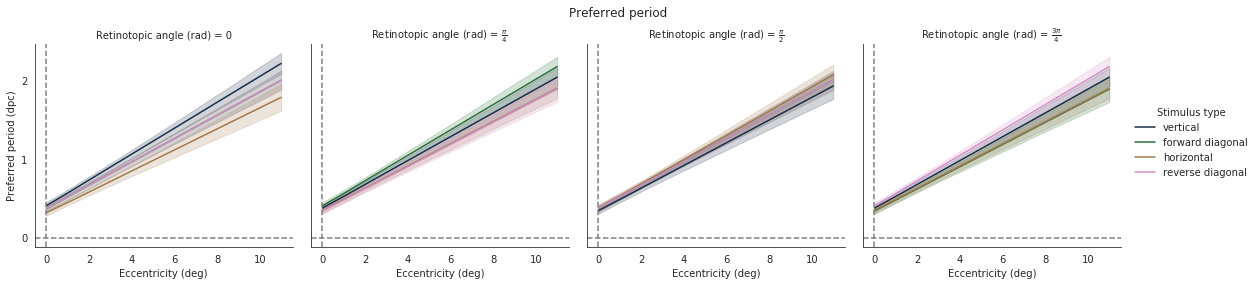

In [250]:
sfp.plotting.feature_df_plot(feat)

In [190]:
b = bootstrap_features(feat, 10000)

In [391]:
fit_model_type = 'full_donut_full_amps-vary'
angles = np.linspace(0, 2*np.pi, 49)
oris = np.linspace(0, np.pi, 4, endpoint=False)
eccens = np.linspace(0, 11, 11)
period_target = [.5, 1, 1.5]
ori_labels = ['radial', 'forward spiral', 'angular', 'reverse spiral']
abs_ori_labels = ['vertical', 'forward diagonal', 'horizontal', 'reverse diagonal']
angle_labels = ['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$']
pal = sns.color_palette('deep', len(ori_labels))
abs_pal = sns.color_palette('cubehelix', len(abs_ori_labels))

indicators = models.indicator.unique()
all_contours = np.empty((len(indicators), len(period_target), len(angles), len(oris)))
all_rel_contours = np.empty_like(all_contours)
all_periods = np.empty((len(indicators), len(angles), len(oris), len(eccens)))
all_rel_periods = np.empty_like(all_periods)
all_amps = np.empty((len(indicators), len(angles), len(oris)))
all_rel_amps = np.empty_like(all_amps)

for j, ind in enumerate(indicators):
    single_model_df = models.query('indicator==@ind & fit_model_type==@fit_model_type')
    model = sfp.model.LogGaussianDonut.init_from_df(single_model_df)
    for k, p in enumerate(period_target):
        all_contours[j, k, :, :] = model.preferred_period_contour(p, angles, oris).detach().numpy()
        all_rel_contours[j, k, :, :] = model.preferred_period_contour(p, angles, rel_sf_angle=oris).detach().numpy()
    all_amps[j, :, :] = model.max_amplitude(angles, oris).detach().numpy()
    all_rel_amps[j, :, :] = model.max_amplitude(angles, rel_sf_angle=oris).detach().numpy()
    for k, a in enumerate(oris):
        all_rel_periods[j, :, k, :] = model.preferred_period(eccens, angles, rel_sf_angle=a).detach().numpy()
        all_periods[j, :, k, :] = model.preferred_period(eccens, angles, a).detach().numpy()

In [392]:
n_bootstraps = 10000
bootstraps = np.random.randint(0, len(indicators), size=(n_bootstraps, len(indicators)))

contours = np.empty((n_bootstraps, len(period_target), len(angles), len(oris)))
rel_contours = np.empty_like(contours)
periods = np.empty((n_bootstraps, len(angles), len(oris), len(eccens)))
rel_periods = np.empty_like(periods)
amps = np.empty((n_bootstraps, len(angles), len(oris)))
rel_amps = np.empty_like(amps)

for i, b in enumerate(bootstraps):
    periods[i, :, :, :] = np.mean(all_periods[b], 0)
    rel_periods[i, :, :, :] = np.mean(all_rel_periods[b], 0)
    contours[i, :, :, :] = np.mean(all_contours[b], 0)
    rel_contours[i, :, :, :] = np.mean(all_rel_contours[b], 0)
    amps[i, :, :] = np.mean(all_amps[b], 0)
    rel_amps[i, :, :] = np.mean(all_rel_amps[b], 0)

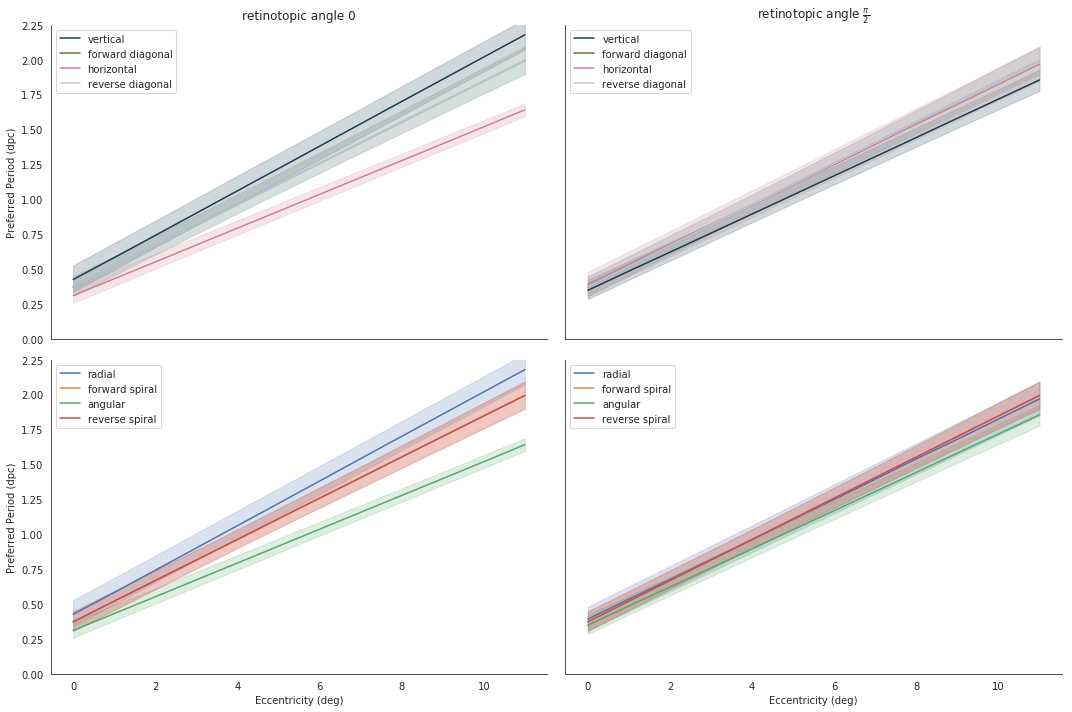

In [208]:
periods_ci = np.percentile(periods, [16, 84], 0)
periods_mn = np.median(periods, 0)
rel_periods_ci = np.percentile(rel_periods, [16, 84], 0)
rel_periods_mn = np.median(rel_periods, 0)
angle_labels_tmp = angle_labels[::2]

fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True, sharex=True,  subplot_kw={'ylim': (0, 2.25)})
for j_idx, j in enumerate(np.where(np.in1d(angles, [0, np.pi/2]))[0]):
    for i in range(4):
        axes[0, j_idx].plot(eccens, periods_mn[j,i,:], label=abs_ori_labels[i], c=abs_pal[i])
        axes[0, j_idx].fill_between(eccens, *periods_ci[:,j,i,:], alpha=.2, color=abs_pal[i])
        axes[1, j_idx].plot(eccens, rel_periods_mn[j,i,:], label=ori_labels[i], c=pal[i])
        axes[1, j_idx].fill_between(eccens, *rel_periods_ci[:,j,i,:], alpha=.2, color=pal[i])
    axes[0,j_idx].set_title('retinotopic angle %s' % angle_labels_tmp[j_idx])
    axes[0,j_idx].legend()
    axes[1,j_idx].legend()
    axes[1, j_idx].set_xlabel("Eccentricity (deg)")
axes[0, 0].set_ylabel("Preferred Period (dpc)")
axes[1, 0].set_ylabel("Preferred Period (dpc)")
plt.tight_layout()
fig.savefig('all_pref_period.svg')

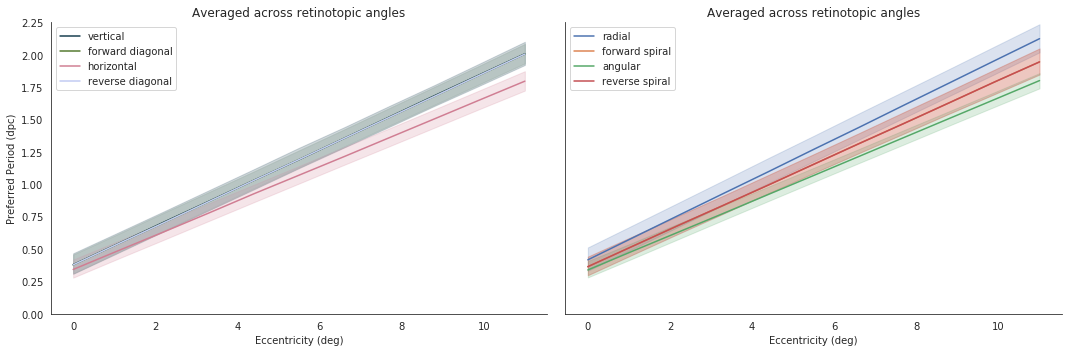

In [105]:
periods_ci = np.percentile(periods.mean(1), [16, 84], 0)
periods_mn = np.median(periods.mean(1), 0)
rel_periods_ci = np.percentile(rel_periods.mean(1), [16, 84], 0)
rel_periods_mn = np.median(rel_periods.mean(1), 0)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True, subplot_kw={'ylim': (0, 2.25)})
for i in range(4):
    axes[0].plot(eccens, periods_mn[i,:], label=abs_ori_labels[i], c=abs_pal[i])
    axes[0].fill_between(eccens, *periods_ci[:,i,:], alpha=.2, color=abs_pal[i])
    axes[1].plot(eccens, rel_periods_mn[i,:], label=ori_labels[i], c=pal[i])
    axes[1].fill_between(eccens, *rel_periods_ci[:,i,:], alpha=.2, color=pal[i])
axes[0].set_title('Averaged across retinotopic angles')
axes[0].legend()
axes[1].set_title('Averaged across retinotopic angles')
axes[1].legend()
axes[0].set_ylabel("Preferred Period (dpc)")
axes[0].set_xlabel("Eccentricity (deg)")
axes[1].set_xlabel("Eccentricity (deg)")
plt.tight_layout()
fig.savefig('pref_period.svg')

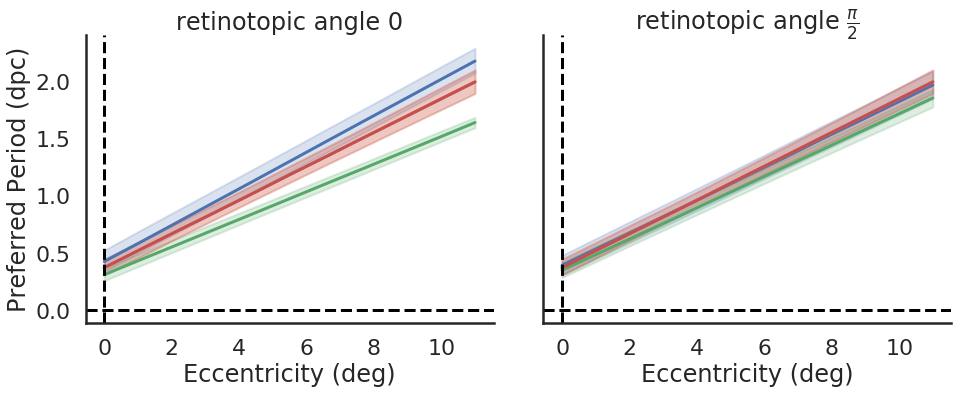

In [359]:
periods_ci = np.percentile(periods, [16, 84], 0)
periods_mn = np.median(periods, 0)
rel_periods_ci = np.percentile(rel_periods, [16, 84], 0)
rel_periods_mn = np.median(rel_periods, 0)
angle_labels_tmp = angle_labels[::2]

with sns.plotting_context('poster'):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True, sharex=True,  )#subplot_kw={'ylim': (0, 2.25)})
    for j_idx, j in enumerate(np.where(np.in1d(angles, [0, np.pi/2]))[0]):
        for i in range(4):
            axes[j_idx].plot(eccens, rel_periods_mn[j,i,:], label=ori_labels[i], c=pal[i])
            axes[j_idx].fill_between(eccens, *rel_periods_ci[:,j,i,:], alpha=.2, color=pal[i])
        axes[j_idx].set_title('retinotopic angle %s' % angle_labels_tmp[j_idx])
        axes[j_idx].set_xlabel("Eccentricity (deg)")
        axes[j_idx].axhline(color='k', linestyle='--')
        axes[j_idx].axvline(color='k', linestyle='--')
    axes[0].set_ylabel("Preferred Period (dpc)")
    plt.tight_layout()
    fig.savefig('all_pref_period.svg')

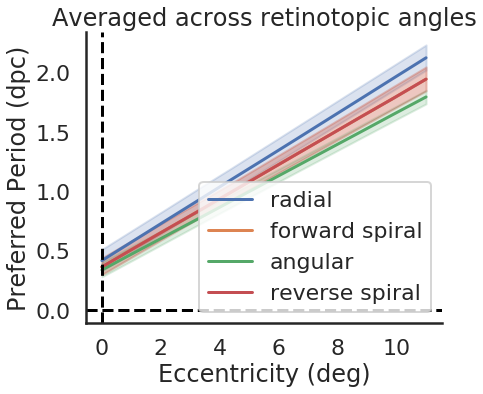

In [365]:
periods_ci = np.percentile(periods.mean(1), [16, 84], 0)
periods_mn = np.median(periods.mean(1), 0)
rel_periods_ci = np.percentile(rel_periods.mean(1), [16, 84], 0)
rel_periods_mn = np.median(rel_periods.mean(1), 0)

with sns.plotting_context('poster'):
    fig, ax = plt.subplots(1, 1, figsize=(7, 6), sharex=True, sharey=True,)#subplot_kw={'ylim': (0, 2.5)})
    for i in range(4):
        ax.plot(eccens, rel_periods_mn[i,:], label=ori_labels[i], c=pal[i])
        ax.fill_between(eccens, *rel_periods_ci[:,i,:], alpha=.2, color=pal[i])
    ax.set_title('Averaged across retinotopic angles')
    ax.legend()
    ax.axhline(color='k', linestyle='--')
    ax.axvline(color='k', linestyle='--')
    ax.set_ylabel("Preferred Period (dpc)")
    ax.set_xlabel("Eccentricity (deg)")
    plt.tight_layout()
    fig.savefig('pref_period.svg')

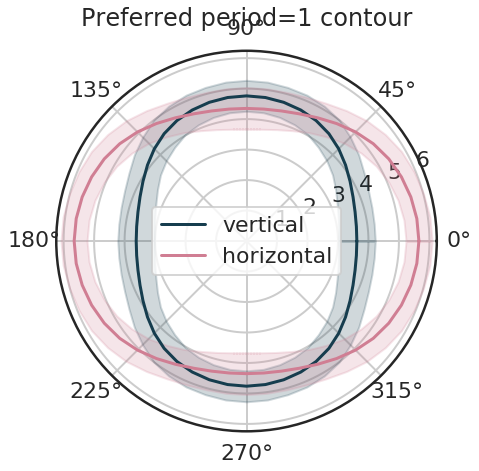

In [366]:
contours_ci = np.percentile(contours, [16, 84], 0)
contours_mn = contours.mean(0)

# with sns.plotting_context('poster'):
#     fig, axes = plt.subplots(1, 3, figsize=(24, 7), subplot_kw={'projection': 'polar'}, sharex=True, sharey=True)
#     for j, ax in enumerate(axes.flatten()):
#         for i in [0, 2, ]:
#             ax.plot(angles, contours_mn[j,:,i], label=abs_ori_labels[i], color=abs_pal[i])
#             ax.fill_between(angles, contours_ci[0,j,:,i], contours_ci[1,j,:,i], alpha=.2, color=abs_pal[i])
#         ax.set_title('Preferred period %s' % period_target[j])
#         ax.legend()
#     fig.savefig('abs_contour.svg')
    
with sns.plotting_context('poster'):
    fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': 'polar'}, sharex=True, sharey=True)
    for i in [0, 2, ]:
        ax.plot(angles, contours_mn[1,:,i], label=abs_ori_labels[i], color=abs_pal[i])
        ax.fill_between(angles, *contours_ci[:,1,:,i], alpha=.2, color=abs_pal[i])
    ax.set_title('Preferred period=%s contour' % period_target[1])
    ax.legend()
    fig.savefig('abs_contour.svg')

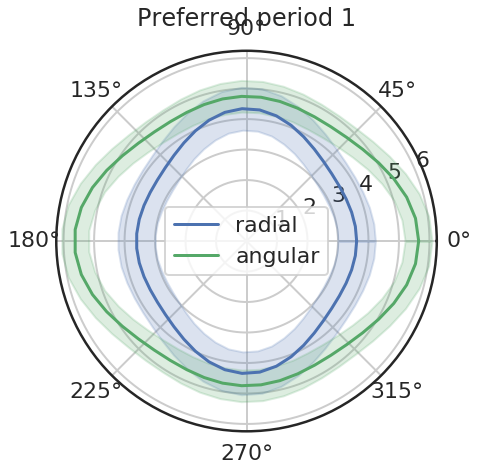

In [130]:
contours_ci = np.percentile(rel_contours, [16, 84], 0)
contours_mn = rel_contours.mean(0)

# with sns.plotting_context('poster'):
#     fig, axes = plt.subplots(1, 3, figsize=(24, 7), subplot_kw={'projection': 'polar'}, sharex=True, sharey=True)
#     for j, ax in enumerate(axes.flatten()):
#         for i in [0, 2]:
#             ax.plot(angles, contours_mn[j,:,i], label=ori_labels[i], color=pal[i])
#             ax.fill_between(angles, contours_ci[0,j,:,i], contours_ci[1,j,:,i], alpha=.2, color=pal[i])
#         ax.set_title('Preferred period %s' % period_target[j])
#         ax.legend()
#     fig.savefig('rel_contour.svg')

with sns.plotting_context('poster'):
    fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': 'polar'}, sharex=True, sharey=True)
    for i in [0, 2]:
        ax.plot(angles, contours_mn[1,:,i], label=ori_labels[i], color=pal[i])
        ax.fill_between(angles, *contours_ci[:,1,:,i], alpha=.2, color=pal[i])
    ax.set_title('Preferred period %s' % period_target[1])
    ax.legend()
    fig.savefig('rel_contour.svg')

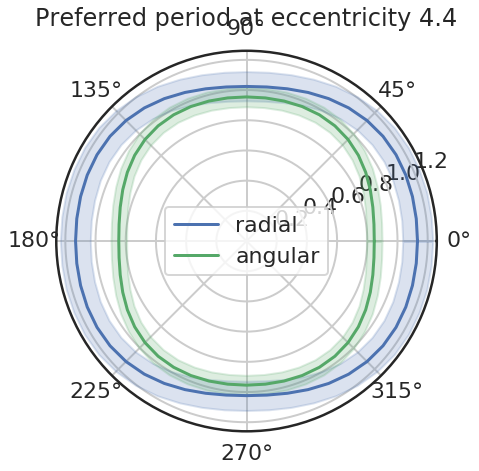

In [219]:
contours_ci = np.percentile(rel_periods, [16, 84], 0)
contours_mn = rel_periods.mean(0)

# with sns.plotting_context('poster'):
#     fig, axes = plt.subplots(1, 3, figsize=(24, 7), subplot_kw={'projection': 'polar'}, sharex=True, sharey=True)
#     for j, ax in enumerate(axes.flatten()):
#         for i in [0, 2]:
#             ax.plot(angles, contours_mn[j,:,i], label=ori_labels[i], color=pal[i])
#             ax.fill_between(angles, contours_ci[0,j,:,i], contours_ci[1,j,:,i], alpha=.2, color=pal[i])
#         ax.set_title('Preferred period %s' % period_target[j])
#         ax.legend()
#     fig.savefig('rel_contour.svg')

with sns.plotting_context('poster'):
    fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': 'polar'}, sharex=True, sharey=True)
    for i in [0, 2]:
        ax.plot(angles, contours_mn[:,i,4], label=ori_labels[i], color=pal[i])
        ax.fill_between(angles, *contours_ci[:,:,i,4], alpha=.2, color=pal[i])
    ax.set_title('Preferred period at eccentricity %.01f' % eccens[4])
    ax.legend()
    fig.savefig('rel_pref_period.svg')

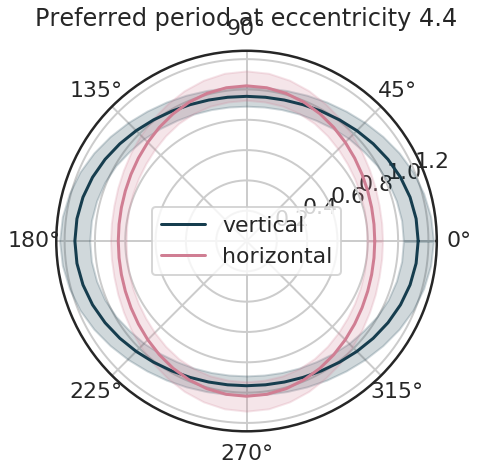

In [225]:
contours_ci = np.percentile(periods, [16, 84], 0)
contours_mn = periods.mean(0)

# with sns.plotting_context('poster'):
#     fig, axes = plt.subplots(1, 3, figsize=(24, 7), subplot_kw={'projection': 'polar'}, sharex=True, sharey=True)
#     for j, ax in enumerate(axes.flatten()):
#         for i in [0, 2]:
#             ax.plot(angles, contours_mn[j,:,i], label=ori_labels[i], color=pal[i])
#             ax.fill_between(angles, contours_ci[0,j,:,i], contours_ci[1,j,:,i], alpha=.2, color=pal[i])
#         ax.set_title('Preferred period %s' % period_target[j])
#         ax.legend()
#     fig.savefig('rel_contour.svg')

with sns.plotting_context('poster'):
    fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': 'polar'}, sharex=True, sharey=True)
    for i in [0, 2]:
        ax.plot(angles, contours_mn[:,i,4], label=abs_ori_labels[i], color=abs_pal[i])
        ax.fill_between(angles, *contours_ci[:,:,i,4], alpha=.2, color=abs_pal[i])
    ax.set_title('Preferred period at eccentricity %.01f' % eccens[4])
    ax.legend()
    fig.savefig('abs_pref_period.svg')

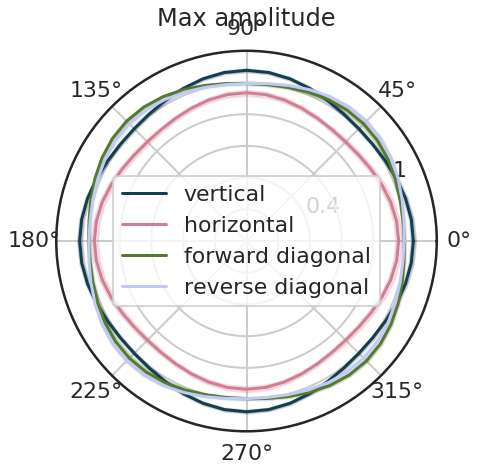

In [449]:
amps_ci = np.percentile(amps, [16, 84], 0)
amps_mn = amps.mean(0)

with sns.plotting_context('poster'):
    fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': 'polar'})
    for i in [0, 2,1,3]:
        ax.plot(angles, amps_mn[:,i], label=abs_ori_labels[i], color=abs_pal[i])
        ax.fill_between(angles, *amps_ci[:,:,i], alpha=.2, color=abs_pal[i])
    ax.set_title('Max amplitude')
    ax.legend()
    ax.set_ylim((0, 1.2))
    ax.set(yticklabels=['', .4, '', '', 1])
    fig.savefig('abs_amps.svg')

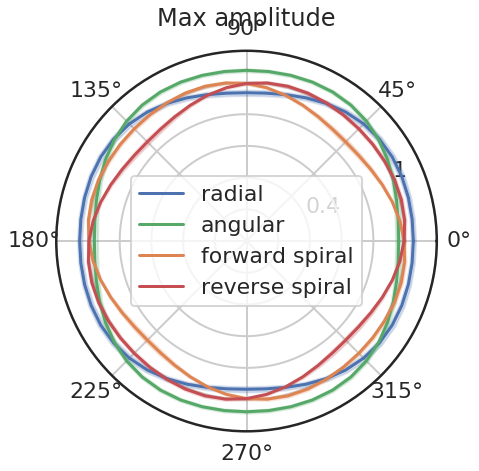

In [450]:
amps_ci = np.percentile(rel_amps, [16, 84], 0)
amps_mn = rel_amps.mean(0)

with sns.plotting_context('poster'):
    fig, ax = plt.subplots(1, 1, figsize=(7,7), subplot_kw={'projection': 'polar'})
    for i in [0, 2,1,3]:
        ax.plot(angles, amps_mn[:,i], label=ori_labels[i], color=pal[i])
        ax.fill_between(angles, *amps_ci[:,:,i], alpha=.2, color=pal[i])
    ax.set_title('Max amplitude')
    ax.legend()
    ax.set_ylim((0, 1.2))
    ax.set(yticklabels=['', .4, '', '', 1])
    fig.savefig('rel_amps.svg')

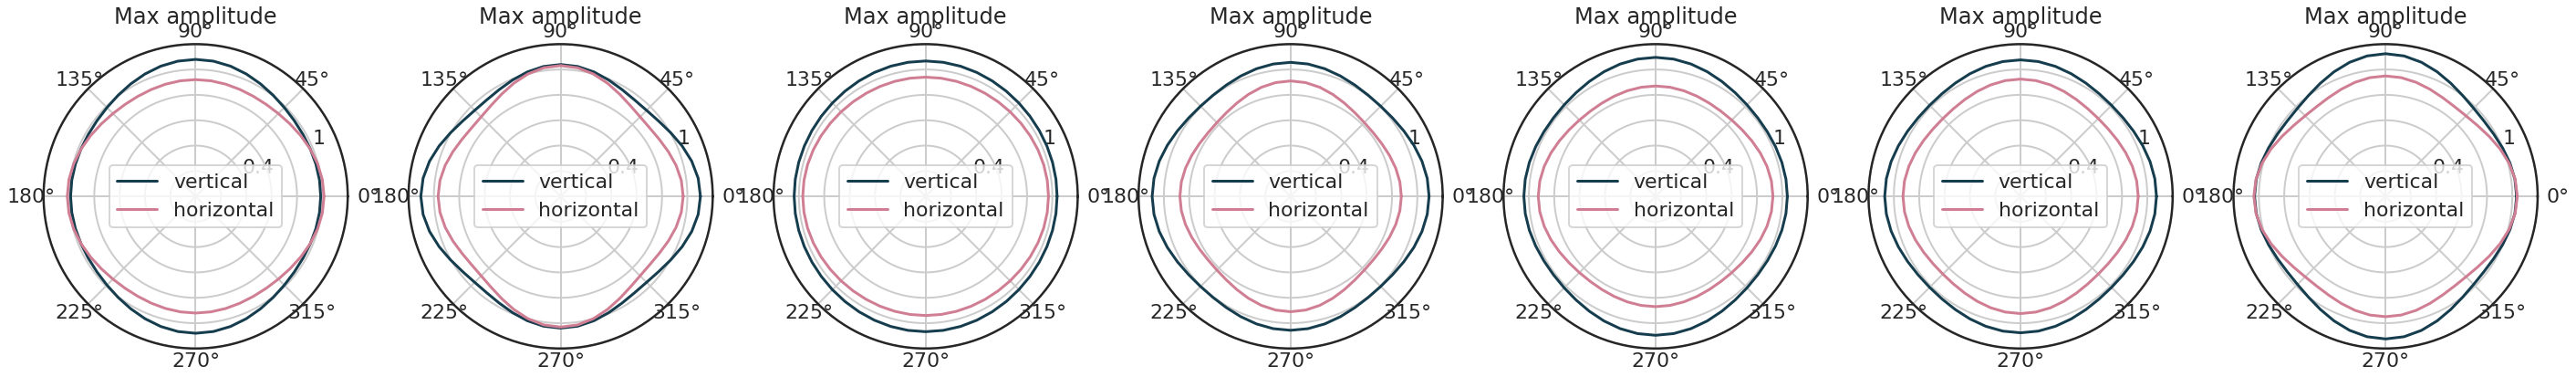

In [245]:
with sns.plotting_context('poster'):
    fig, axes = plt.subplots(1, 7, figsize=(49, 7), subplot_kw={'projection': 'polar'})
    for j, ax in enumerate(axes.flatten()):
        for i in [0, 2]:
            ax.plot(angles, all_amps[j,:,i], label=abs_ori_labels[i], color=abs_pal[i])
        ax.set_title('Max amplitude')
        ax.legend()
        ax.set_ylim((0, 1.2))
        ax.set(yticklabels=['', .4, '', '', 1])

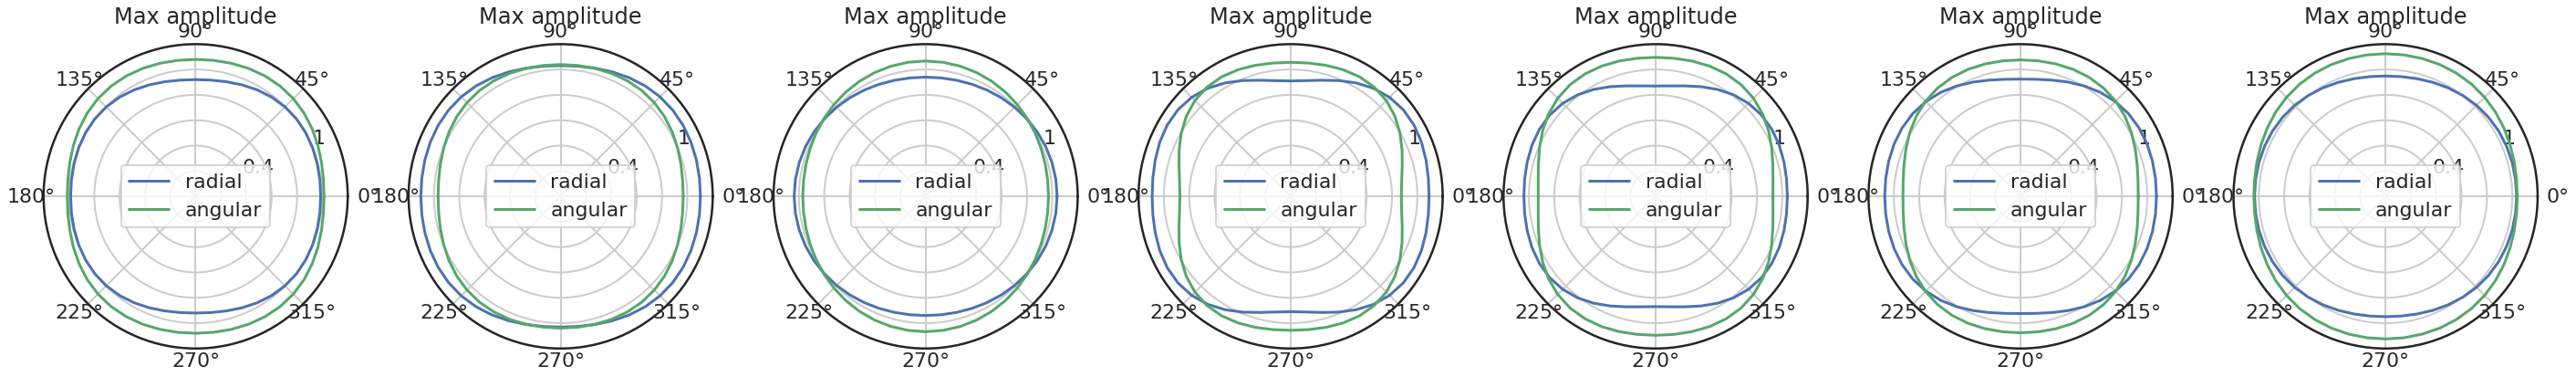

In [394]:
with sns.plotting_context('poster'):
    fig, axes = plt.subplots(1, 7, figsize=(49, 7), subplot_kw={'projection': 'polar'})
    for j, ax in enumerate(axes.flatten()):
        for i in [0, 2]:
            ax.plot(angles, all_rel_amps[j,:,i], label=ori_labels[i], color=pal[i])
        ax.set_title('Max amplitude')
        ax.legend()
        ax.set_ylim((0, 1.2))
        ax.set(yticklabels=['', .4, '', '', 1])

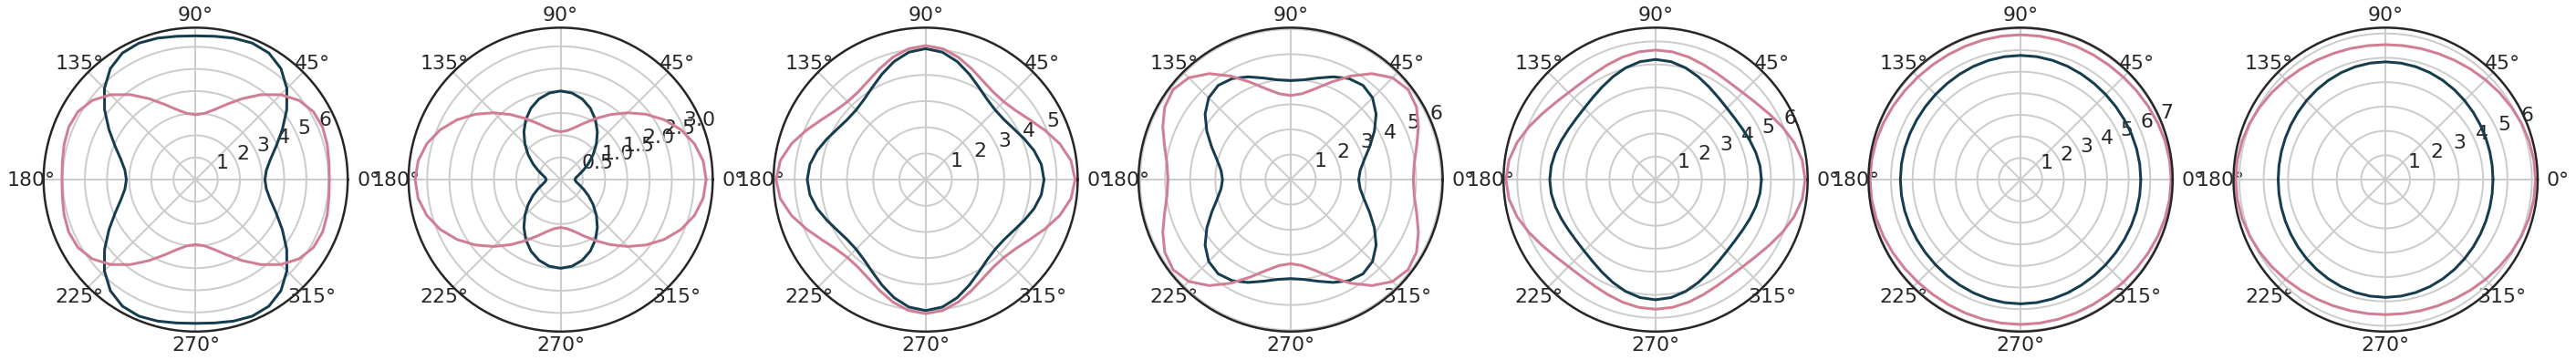

In [246]:
with sns.plotting_context('poster'):
    fig, axes = plt.subplots(1, 7, figsize=(49, 7), subplot_kw={'projection': 'polar'})
    for j, ax in enumerate(axes.flatten()):
        for i in [0, 2]:
            ax.plot(angles, all_contours[j,1,:,i], label=abs_ori_labels[i], color=abs_pal[i])

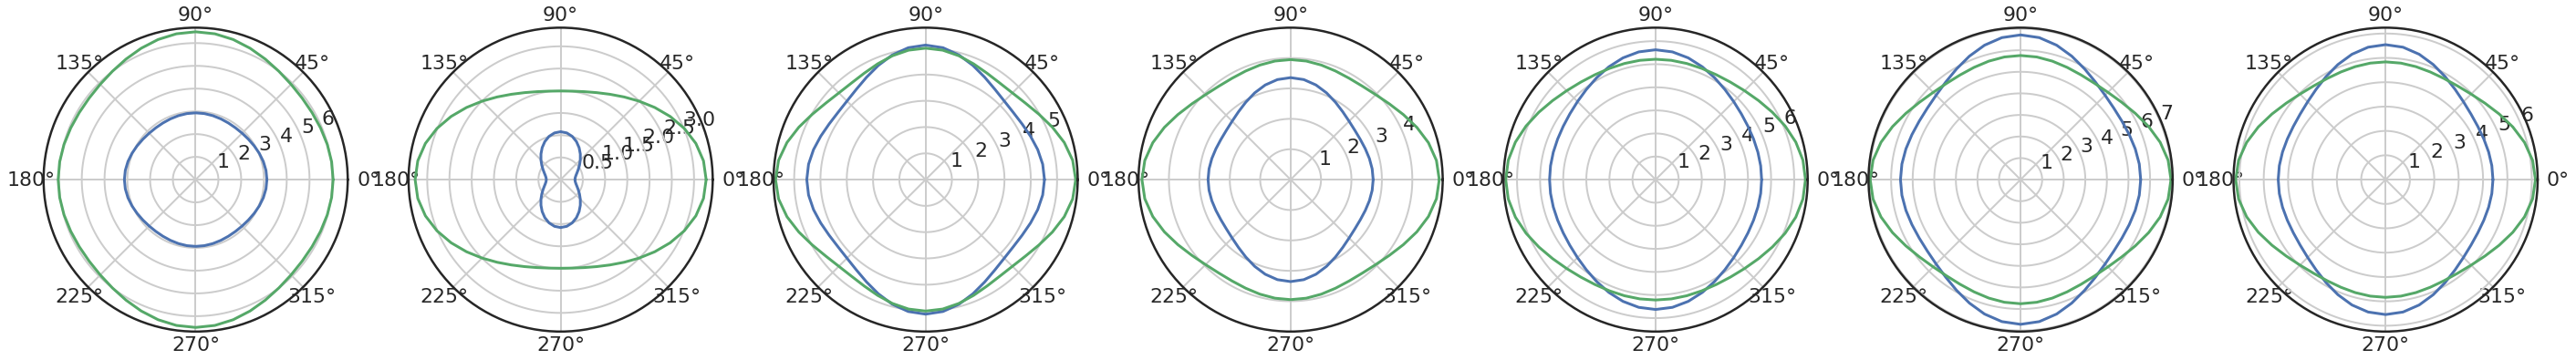

In [393]:
with sns.plotting_context('poster'):
    fig, axes = plt.subplots(1, 7, figsize=(49, 7), subplot_kw={'projection': 'polar'})
    for j, ax in enumerate(axes.flatten()):
        for i in [0, 2]:
            ax.plot(angles, all_rel_contours[j,1,:,i], label=ori_labels[i], color=pal[i])

In [383]:
original_param_names = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept', 'abs_mode_cardinals', 'abs_mode_obliques', 'rel_mode_cardinals', 'rel_mode_obliques',
                        'abs_amplitude_cardinals', 'abs_amplitude_obliques', 'rel_amplitude_cardinals', 'rel_amplitude_obliques']
rename_params = dict((k, v) for k, v in zip(original_param_names, parameters))
tmp = models.query('fit_model_type==@fit_model_type')
tmp = tmp.set_index('model_parameter')
tmp.loc['sigma', 'param_category'] = 'sigma'
tmp.loc[['sf_ecc_slope', 'sf_ecc_intercept'], 'param_category'] = 'eccen'
tmp.loc[['abs_mode_cardinals', 'abs_mode_obliques', 'rel_mode_cardinals', 'rel_mode_obliques',
         'abs_amplitude_cardinals', 'abs_amplitude_obliques', 'rel_amplitude_cardinals', 'rel_amplitude_obliques'], 'param_category'] = 'orientation'
tmp = tmp.reset_index()
tmp['model_parameter'] = tmp.model_parameter.map(rename_params)

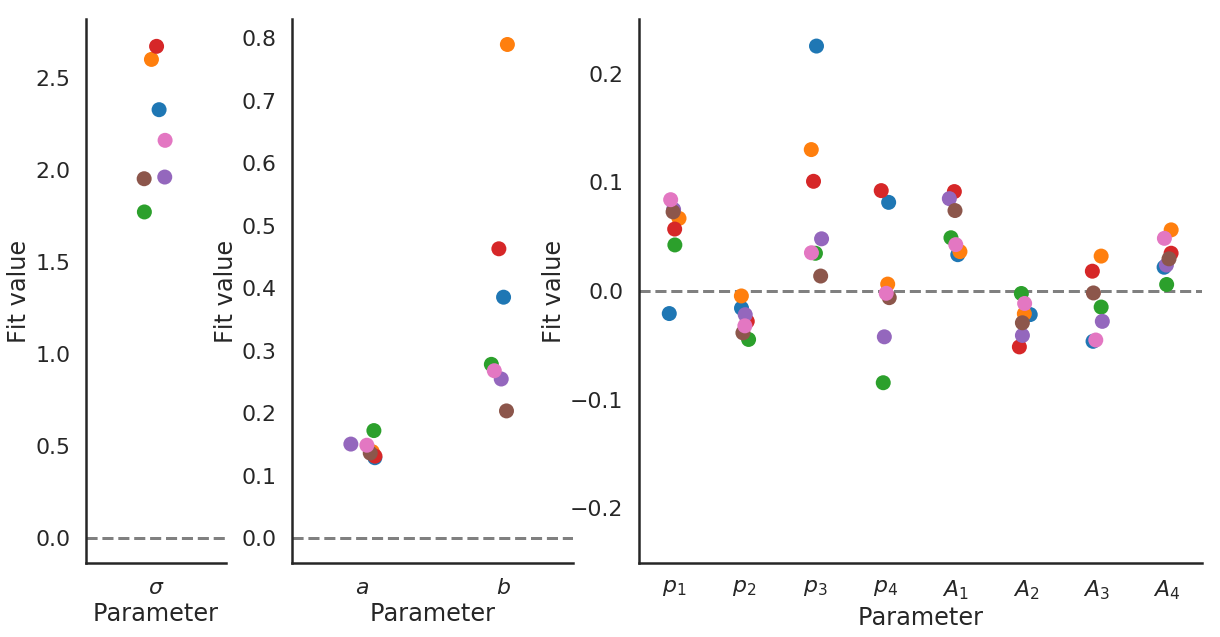

In [448]:
with sns.plotting_context('poster', font_scale=1):
    fig, axes = plt.subplots(1, 3, figsize=(20, 10), gridspec_kw={'width_ratios': [.15, .3, .6]})
    for i, ax in enumerate(axes):
        cat = ['sigma', 'eccen', 'orientation'][i]
        tmp_order = [i for i in parameters if i in tmp.query("param_category==@cat").model_parameter.unique()]
        sns.stripplot('model_parameter', 'fit_value', 'indicator', data=tmp.query("param_category==@cat"), s=15, ax=ax, order=tmp_order)
        if ax.legend_:
            ax.legend_.remove()
        if i==2:
            ax.set(ylim=(-.25, .25))
        ax.axhline(color='grey', linestyle='dashed')
        ax.set(ylabel='Fit value', xlabel='Parameter')
    #fig.savefig('param_vals.svg')